# Project Overview

### Project Name:
**End to End Brazilian E-Commerce Analysis**

### Objective:
The primary goal of this project is to build an end-to-end data pipeline for analyzing Brazilian e-commerce data. The project integrates data from Snowflake, processes it using PySpark, and loads the results into PostgreSQL for further analysis and reporting.

### Key Components

**Data Extraction:**

- **Source:** Snowflake
- **Purpose:** Extract relevant datasets from Snowflake that include order reviews, customer information, order details, payment data, and product attributes.

**Data Processing:**

- **Tool:** PySpark
- **Purpose:** Process and transform the extracted data to generate insights related to various e-commerce metrics. This includes:
  - **NLP Data Mart:** Analyzing review comments and product categories to extract sentiment and trends.
    - **Word Cloud Analysis:** Visualizing frequent terms in customer reviews to identify common themes and sentiments.
    - **Bi-gram Analysis:** Identifying and analyzing frequently occurring word pairs to understand common phrases and patterns in the reviews.
  - **Customer Satisfaction Analysis:** Assessing customer satisfaction based on review scores, order status, and payment details.
  - **Clustering Analysis:** Evaluating product characteristics and review scores to identify patterns for clustering.
  - **Sales Analysis:** Analyzing sales trends, including product prices, freight values, and delivery dates.

**Data Loading:**

- **Destination:** PostgreSQL
- **Purpose:** Store the processed data into PostgreSQL tables for easy access and further analysis. The tables include:
  - **nlp_data_mart:** Insights into review comments and product categories.
  - **customer_satisfaction_data_mart:** Metrics on customer satisfaction and order details.
  - **clustering_data_mart:** Data for clustering analysis based on product and review characteristics.
  - **sales_analysis_data_mart:** Analysis of sales data by product and region.

**Machine Learning and Insights:**

- **Tool:** Scikit Learn
- **Purpose:** Build machine learning models to derive actionable insights from the data.
  
- **Tool:** Google Gemini
- **Purpose:** Obtain insights from machine learning models and perform advanced NLP analysis.

**Data Visualization:**

- **Tool:** Power BI
- **Purpose:** Create interactive visualizations and dashboards to facilitate data exploration and reporting.

**Data Pipeline Automation:**

- **Tool:** Prefect
- **Purpose:** Automate the end-to-end data pipeline, ensuring that data extraction, processing, and loading are performed on a scheduled basis with monitoring and error handling.

### Reasoning

**Business Needs:**

- **NLP Data Mart:** Extracting insights from customer reviews helps in understanding customer sentiment and improving product offerings. 
  - **Word Cloud Analysis:** Provides a visual representation of frequent terms to identify key themes.
  - **Bi-gram Analysis:** Reveals common word pairs to understand prevalent phrases and context in reviews.
- **Customer Satisfaction:** Analyzing customer satisfaction metrics aids in identifying areas for improvement and enhancing customer experience.
- **Clustering Analysis:** Identifying product and review patterns supports targeted marketing and product development strategies.
- **Sales Analysis:** Insights into sales trends and metrics help in optimizing inventory, pricing strategies, and sales performance.
- **Machine Learning Modeling:** Utilizing machine learning models to uncover deeper patterns and predictive insights.
- **Data Visualization:** Creating dashboards and visualizations to present findings in an accessible and actionable manner.

**Technical Approach:**

- **Snowflake:** Chosen as the data source due to its ability to handle large-scale data storage and integration with Spark.
- **PySpark:** Provides a powerful framework for distributed data processing, capable of managing complex transformations and large datasets.
- **PostgreSQL:** Selected as the destination database for its robustness and compatibility with analytical tools.
- **Scikit Learn:** Used for developing machine learning models to enhance analysis.
- **Google Gemini:** Provides advanced insights from machine learning models and NLP analysis.
- **Power BI:** Selected for its capabilities in creating dynamic and interactive data visualizations and dashboards.
- **Prefect:** Utilized for workflow orchestration, offering features for scheduling, monitoring, and error handling.

**Integration:**

The integration of Snowflake, PySpark, PostgreSQL, Scikit Learn, Google Gemini, Power BI, and Prefect ensures a comprehensive end-to-end pipeline, facilitating efficient data extraction, processing, analysis, and visualization.

**Scalability and Maintainability:**

The architecture is designed to handle increasing data volumes and complexity. Prefect’s workflow management capabilities ensure the pipeline remains maintainable and adaptable to future changes or enhancements.

# Tools that will be used

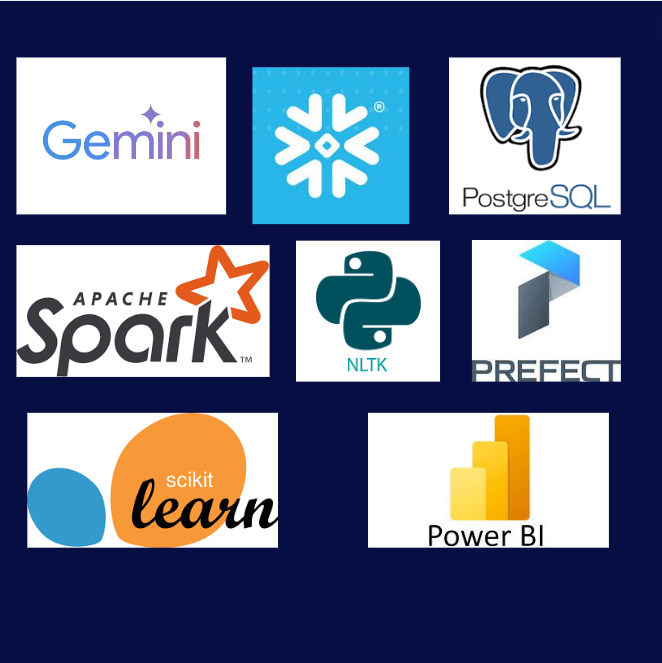

# Project Workflow

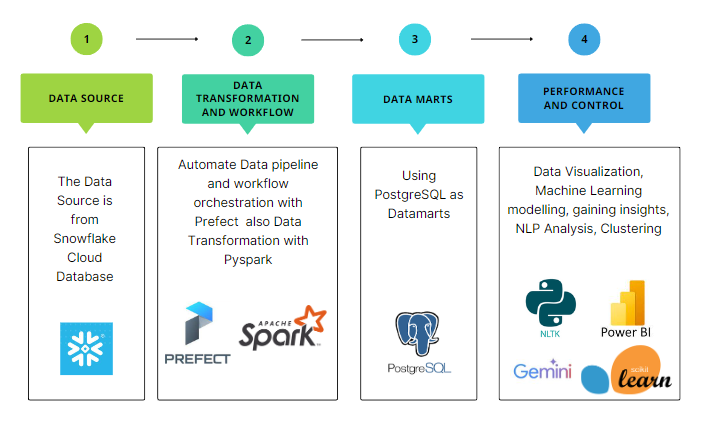

# ERD Diagram

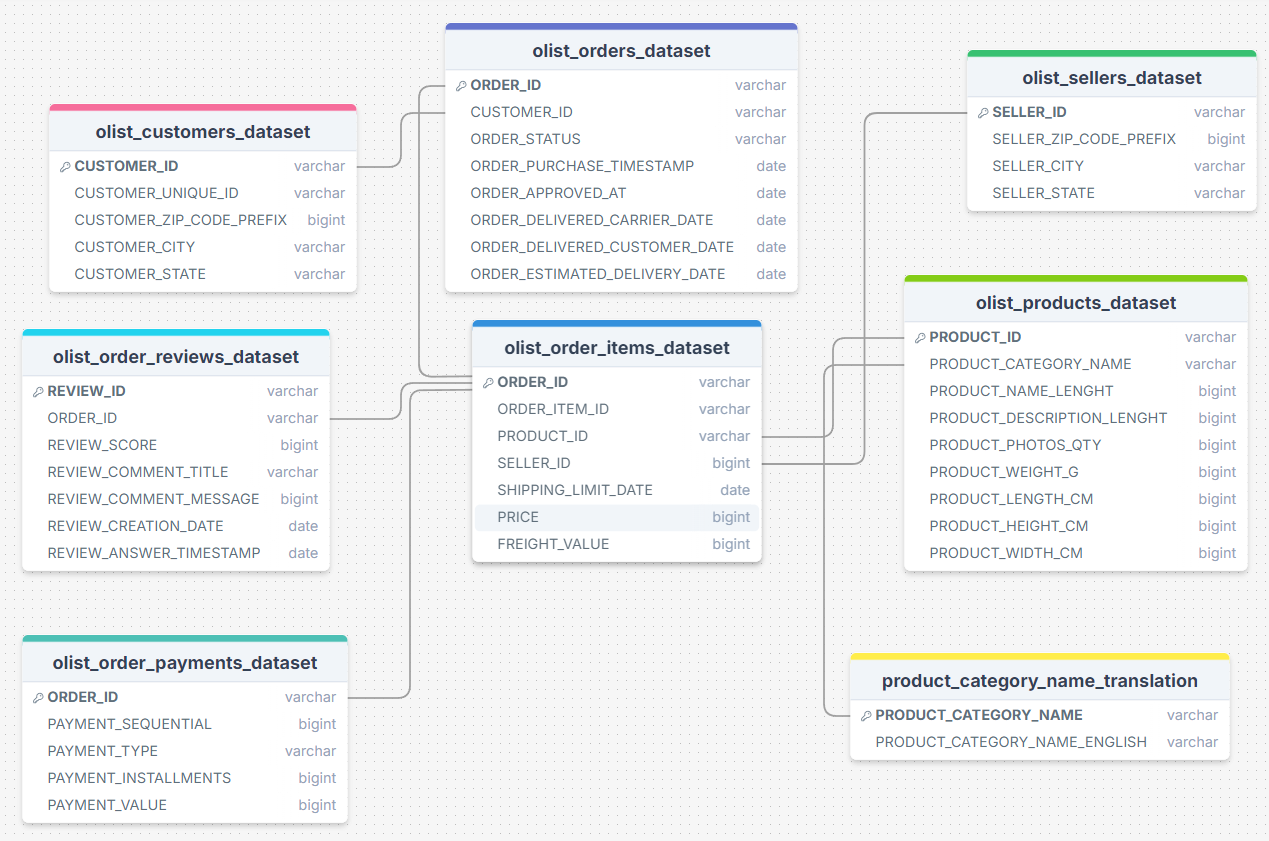

# Workflow Orchestration and Data Processing with Pyspark and Prefect

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
from prefect import task, flow
import psycopg2

# Initialize SparkSession with Snowflake and PostgreSQL JDBC drivers
spark = SparkSession.builder \
    .appName("SnowflakeToPostgreSQL") \
    .config("spark.jars", "C:\\Users\\Michael\\Pyspark\\snowflake-jdbc-3.13.30.jar,C:\\Users\\Michael\\Pyspark\\spark-snowflake_2.12-2.13.0-spark_3.4.jar,C:\\Users\\Michael\\Pyspark\\postgresql-42.7.3.jar") \
    .getOrCreate()

# Snowflake connection options
sfOptions = {
    "sfURL": "https://ar37313.europe-west4.gcp.snowflakecomputing.com",
    "sfAccount": "ar37313.europe-west4.gcp",
    "sfUser": "MAGICDASH",
    "sfPassword": "*****************************",
    "sfDatabase": "ECOMMERCE",
    "sfSchema": "PUBLIC",
    "sfWarehouse": "COMPUTE_WH",
    "sfRole": "ACCOUNTADMIN"
}

SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

# PostgreSQL connection options
jdbc_url = "jdbc:postgresql://localhost:5432/project3"
connection_properties = {
    "user": "postgres",
    "password": "*****************************",
    "driver": "org.postgresql.Driver"
}

# PostgreSQL connection for schema checking and altering
def get_postgresql_connection():
    return psycopg2.connect(
        dbname="project3",
        user="postgres",
        password="**************************",
        host="localhost",
        port="5432"
    )

@task
def check_table_exists(table_name: str) -> bool:
    try:
        conn = get_postgresql_connection()
        cursor = conn.cursor()
        cursor.execute(f"SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = '{table_name}');")
        exists = cursor.fetchone()[0]
        cursor.close()
        conn.close()
        return exists
    except Exception as e:
        print("Error checking table existence:", e)
        return False

@task
def execute_query(query: str, table_name: str):
    try:
        # Read data from Snowflake using SQL query
        df = spark.read \
            .format(SNOWFLAKE_SOURCE_NAME) \
            .options(**sfOptions) \
            .option("query", query) \
            .load()

        # Check if table exists in PostgreSQL
        if check_table_exists(table_name):
            print(f"Table '{table_name}' exists. Replacing the table.")
            df.write \
                .format("jdbc") \
                .option("url", jdbc_url) \
                .option("dbtable", table_name) \
                .option("user", connection_properties["user"]) \
                .option("password", connection_properties["password"]) \
                .option("driver", connection_properties["driver"]) \
                .mode("overwrite") \
                .save()
        else:
            print(f"Table '{table_name}' does not exist. Creating and writing to the table.")
            df.write \
                .format("jdbc") \
                .option("url", jdbc_url) \
                .option("dbtable", table_name) \
                .option("user", connection_properties["user"]) \
                .option("password", connection_properties["password"]) \
                .option("driver", connection_properties["driver"]) \
                .mode("overwrite") \
                .save()

        print(f"Data written to PostgreSQL table '{table_name}' successfully!")

    except AnalysisException as e:
        print("AnalysisException:", e)
    except Exception as e:
        print("Exception:", e)

@flow
def data_pipeline():
    # Define SQL queries
    nlp_data_mart_query = """
    SELECT 
        R.REVIEW_COMMENT_MESSAGE,
        CT.PRODUCT_CATEGORY_NAME_ENGLISH
    FROM PUBLIC.OLIST_ORDER_REVIEWS_DATASET R
    JOIN PUBLIC.OLIST_ORDERS_DATASET O ON R.ORDER_ID = O.ORDER_ID
    JOIN PUBLIC.OLIST_ORDER_ITEMS_DATASET I ON O.ORDER_ID = I.ORDER_ID
    JOIN PUBLIC.OLIST_PRODUCTS_DATASET P ON I.PRODUCT_ID = P.PRODUCT_ID
    JOIN PUBLIC.PRODUCT_CATEGORY_NAME_TRANSLATION CT ON P.PRODUCT_CATEGORY_NAME = CT.PRODUCT_CATEGORY_NAME
    WHERE R.REVIEW_COMMENT_MESSAGE IS NOT NULL
    """

    customer_satisfaction_data_mart_query = """
    SELECT 
        C.CUSTOMER_STATE,
        R.REVIEW_SCORE,
        O.ORDER_STATUS,
        P.PAYMENT_TYPE,
        P.PAYMENT_VALUE,
        O.ORDER_PURCHASE_TIMESTAMP,
        O.ORDER_DELIVERED_CUSTOMER_DATE,
        CT.PRODUCT_CATEGORY_NAME_ENGLISH
    FROM PUBLIC.OLIST_CUSTOMERS_DATASET C
    JOIN PUBLIC.OLIST_ORDERS_DATASET O ON C.CUSTOMER_ID = O.CUSTOMER_ID
    JOIN PUBLIC.OLIST_ORDER_REVIEWS_DATASET R ON O.ORDER_ID = R.ORDER_ID
    JOIN PUBLIC.OLIST_ORDER_PAYMENTS_DATASET P ON O.ORDER_ID = P.ORDER_ID
    JOIN PUBLIC.OLIST_ORDER_ITEMS_DATASET I ON O.ORDER_ID = I.ORDER_ID
    JOIN PUBLIC.OLIST_PRODUCTS_DATASET PR ON I.PRODUCT_ID = PR.PRODUCT_ID
    JOIN PUBLIC.PRODUCT_CATEGORY_NAME_TRANSLATION CT ON PR.PRODUCT_CATEGORY_NAME = CT.PRODUCT_CATEGORY_NAME
    """

    clustering_data_mart_query = """
    SELECT 
        I.PRICE,
        I.FREIGHT_VALUE,
        P.PRODUCT_WEIGHT_G,
        P.PRODUCT_LENGTH_CM,
        P.PRODUCT_HEIGHT_CM,
        P.PRODUCT_WIDTH_CM,
        R.REVIEW_SCORE,
        CT.PRODUCT_CATEGORY_NAME_ENGLISH
    FROM PUBLIC.OLIST_ORDERS_DATASET O
    JOIN PUBLIC.OLIST_ORDER_ITEMS_DATASET I ON O.ORDER_ID = I.ORDER_ID
    JOIN PUBLIC.OLIST_PRODUCTS_DATASET P ON I.PRODUCT_ID = P.PRODUCT_ID
    LEFT JOIN PUBLIC.OLIST_ORDER_REVIEWS_DATASET R ON O.ORDER_ID = R.ORDER_ID
    JOIN PUBLIC.PRODUCT_CATEGORY_NAME_TRANSLATION CT ON P.PRODUCT_CATEGORY_NAME = CT.PRODUCT_CATEGORY_NAME
    """

    sales_analysis_data_mart_query = """
    SELECT 
        I.PRICE,
        I.FREIGHT_VALUE,
        O.ORDER_PURCHASE_TIMESTAMP,
        O.ORDER_DELIVERED_CUSTOMER_DATE,
        CT.PRODUCT_CATEGORY_NAME_ENGLISH
    FROM PUBLIC.OLIST_ORDERS_DATASET O
    JOIN PUBLIC.OLIST_ORDER_ITEMS_DATASET I ON O.ORDER_ID = I.ORDER_ID
    JOIN PUBLIC.OLIST_SELLERS_DATASET S ON I.SELLER_ID = S.SELLER_ID
    JOIN PUBLIC.OLIST_PRODUCTS_DATASET P ON I.PRODUCT_ID = P.PRODUCT_ID
    JOIN PUBLIC.PRODUCT_CATEGORY_NAME_TRANSLATION CT ON P.PRODUCT_CATEGORY_NAME = CT.PRODUCT_CATEGORY_NAME
    """

    # Call tasks within the flow
    execute_query(nlp_data_mart_query, "nlp_data_mart")
    execute_query(customer_satisfaction_data_mart_query, "customer_satisfaction_data_mart")
    execute_query(clustering_data_mart_query, "clustering_data_mart")
    execute_query(sales_analysis_data_mart_query, "sales_analysis_data_mart")

# Run the flow
if __name__ == "__main__":
    data_pipeline()

# Stop the Spark session
spark.stop()


# Prefect Workflow Orchestration

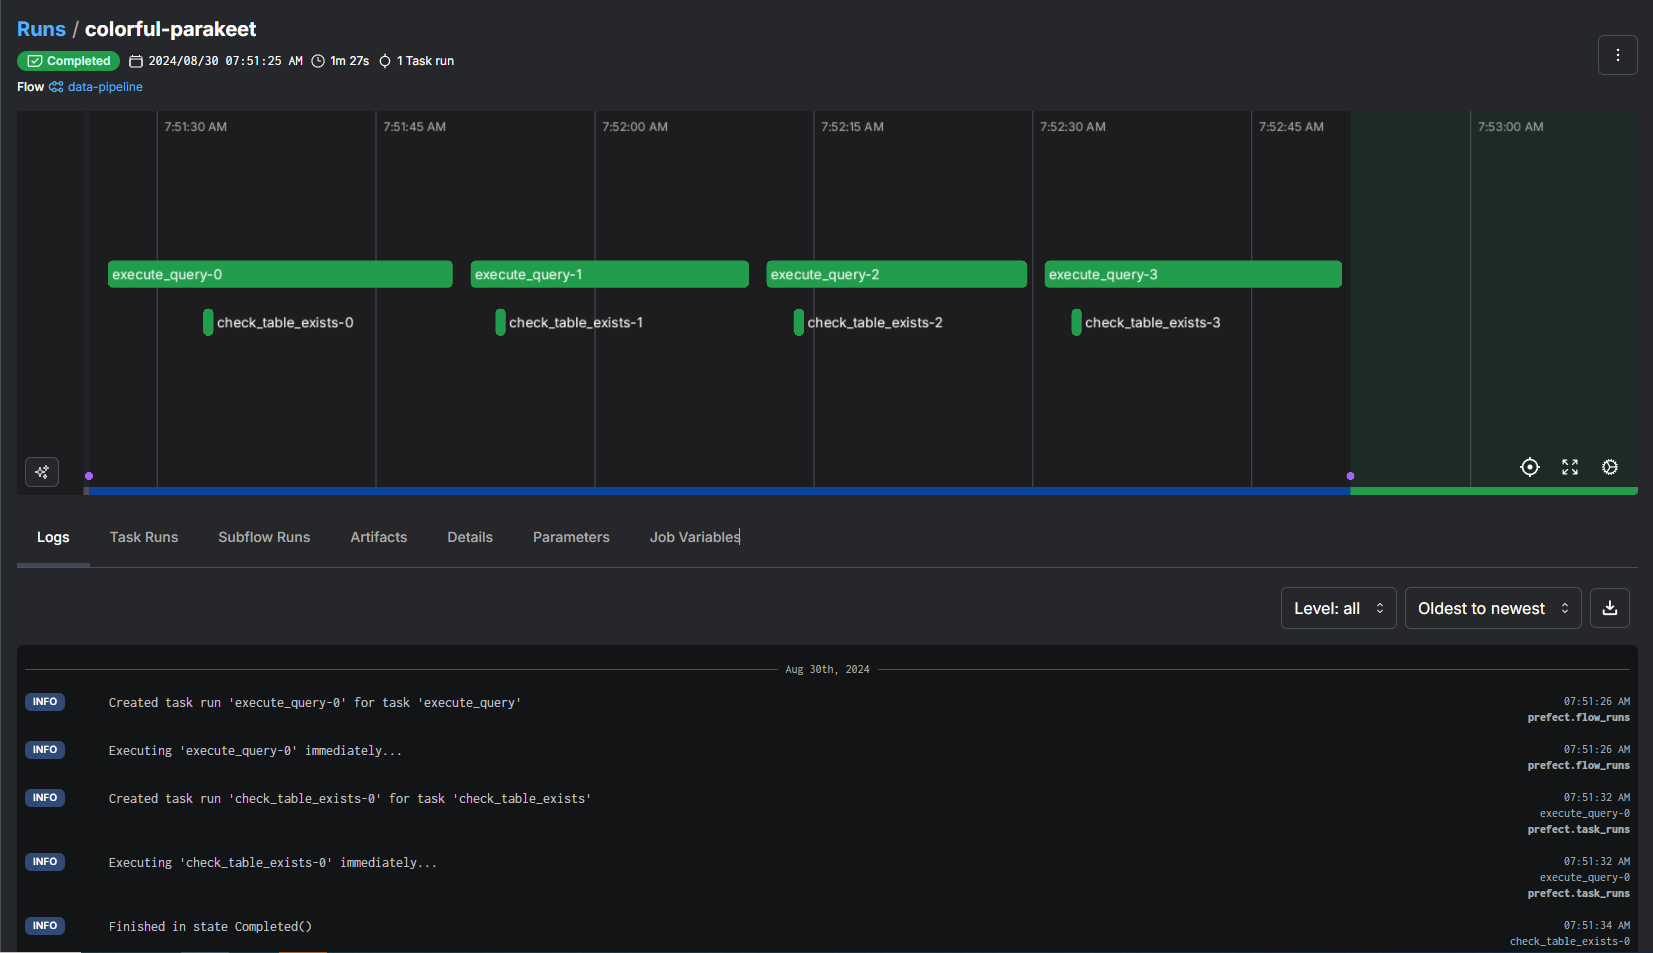

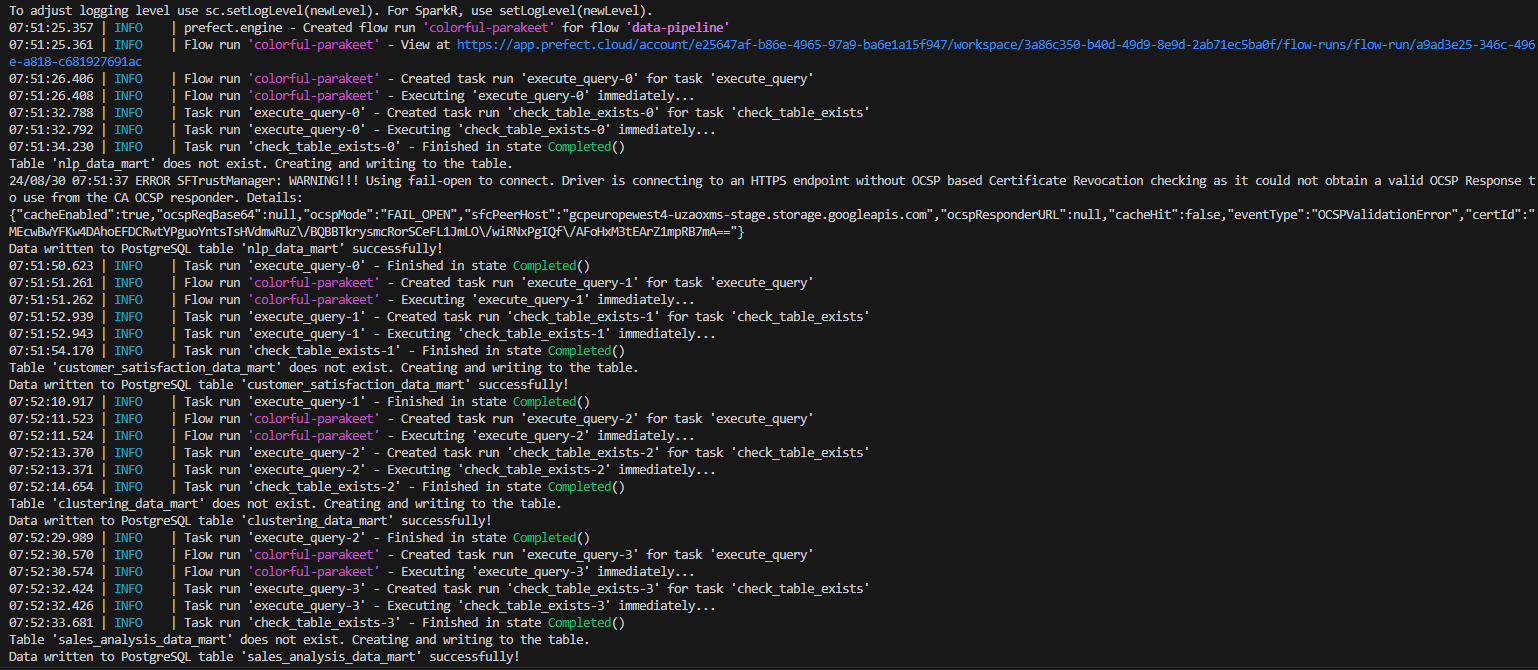

# Connect to PostgreSQL Datamart with Psycopg

In [1]:
import pandas as pd
import psycopg2
from psycopg2 import OperationalError

try:
    # Attempt to establish a connection to PostgreSQL
    connection = psycopg2.connect(
        host="localhost",
        dbname="project3",
        user="postgres",
        password="permataputihg101",
        port="5432"
    )
    print("Connection Success")
    
except OperationalError as e:
    print("Connection Failed")
    print(f"Error details: {e}")

Connection Success


# Customer Satisfaction Prediction and Analysis

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)

In [3]:
query = "SELECT * FROM public.customer_satisfaction_data_mart"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_9552\1051363282.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,CUSTOMER_STATE,REVIEW_SCORE,ORDER_STATUS,PAYMENT_TYPE,PAYMENT_VALUE,ORDER_PURCHASE_TIMESTAMP,ORDER_DELIVERED_CUSTOMER_DATE,PRODUCT_CATEGORY_NAME_ENGLISH
0,RJ,5.0,delivered,credit_card,72.19,2017-09-13 08:59:02,2017-09-20 23:43:48,cool_stuff
1,SP,4.0,delivered,credit_card,259.83,2017-04-26 10:53:06,2017-05-12 16:04:24,pet_shop
2,MG,5.0,delivered,credit_card,216.87,2018-01-14 14:33:31,2018-01-22 13:19:16,furniture_decor
3,SP,4.0,delivered,credit_card,25.78,2018-08-08 10:00:35,2018-08-14 13:32:39,perfumery
4,SP,5.0,delivered,credit_card,218.04,2017-02-04 13:57:51,2017-03-01 16:42:31,garden_tools


### Data Processing

In [4]:
# Drop ORDER_PURCHASE_TIMESTAMP and ORDER_DELIVERED_CUSTOMER_DATE
df.drop(columns=["ORDER_PURCHASE_TIMESTAMP", "ORDER_DELIVERED_CUSTOMER_DATE"], inplace=True)
df.head()

,CUSTOMER_STATE,REVIEW_SCORE,ORDER_STATUS,PAYMENT_TYPE,PAYMENT_VALUE,PRODUCT_CATEGORY_NAME_ENGLISH
0,RJ,5.0,delivered,credit_card,72.19,cool_stuff
1,SP,4.0,delivered,credit_card,259.83,pet_shop
2,MG,5.0,delivered,credit_card,216.87,furniture_decor
3,SP,4.0,delivered,credit_card,25.78,perfumery
4,SP,5.0,delivered,credit_card,218.04,garden_tools


In [5]:
#Check the number of unique value from all of the object datatype
df.select_dtypes(include='object').nunique()

CUSTOMER_STATE                   27
ORDER_STATUS                      7
PAYMENT_TYPE                      4
PRODUCT_CATEGORY_NAME_ENGLISH    71
dtype: int64

### Segment PRODUCT_CATEGORY_NAME_ENGLISH into smaller unique value

In [6]:
df['PRODUCT_CATEGORY_NAME_ENGLISH'].unique()

array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'cine_p

In [7]:
def segment_product_category(category):
    if category in ['electronics', 'computers', 'computers_accessories', 'tablets_printing_image']:
        return 'Electronics'
    elif category in ['fashion_bags_accessories', 'fashion_underwear_beach', 'fashion_male_clothing', 'fashion_female_clothing', 'fashion_shoes', 'fashion_childrens_clothes', 'fashion_sport']:
        return 'Fashion'
    elif category in ['furniture_decor', 'furniture_living_room', 'furniture_bedroom', 'furniture_mattress_and_upholstery', 'kitchen_dining_laundry_garden_furniture']:
        return 'Furniture'
    elif category in ['health_beauty', 'baby', 'diapers_and_hygiene', 'signaling_and_security']:
        return 'Health & Beauty'
    elif category in ['home_appliances', 'home_appliances_2', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'costruction_tools_tools']:
        return 'Home Appliances'
    elif category in ['books_general_interest', 'books_imported', 'books_technical']:
        return 'Books'
    elif category in ['food', 'drinks', 'party_supplies']:
        return 'Food & Drink'
    elif category in ['sports_leisure', 'toys']:
        return 'Sports & Toys'
    elif category in ['office_furniture', 'stationery', 'cine_photo']:
        return 'Office Supplies'
    elif category in ['auto', 'construction_tools_construction', 'costruction_tools_garden']:
        return 'Automotive & Construction'
    elif category in ['art', 'arts_and_craftmanship']:
        return 'Art & Crafts'
    elif category in ['music', 'cds_dvds_musicals', 'dvds_blu_ray']:
        return 'Music & Movies'
    elif category in ['market_place', 'watches_gifts', 'luggage_accessories']:
        return 'Gifts & Accessories'
    elif category in ['garden_tools', 'costruction_tools_lights', 'costruction_tools_safety']:
        return 'Garden & Construction Tools'
    elif category in ['air_conditioning', 'home_confort', 'home_construction']:
        return 'Home Improvement'
    elif category in ['party_supplies', 'flowers']:
        return 'Events & Gifts'
    elif category in ['baby', 'diapers_and_hygiene']:
        return 'Baby & Childcare'
    elif category in ['musical_instruments', 'audio']:
        return 'Music & Audio'
    elif category in ['industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Commerce'
    elif category in ['christmas_supplies', 'fashion_underwear_beach']:
        return 'Seasonal & Special Occasion'
    else:
        return 'Other'

# Apply the segmentation function to the DataFrame
df['PRODUCT_CATEGORY_NAME_ENGLISH'] = df['PRODUCT_CATEGORY_NAME_ENGLISH'].apply(segment_product_category)

<Axes: >

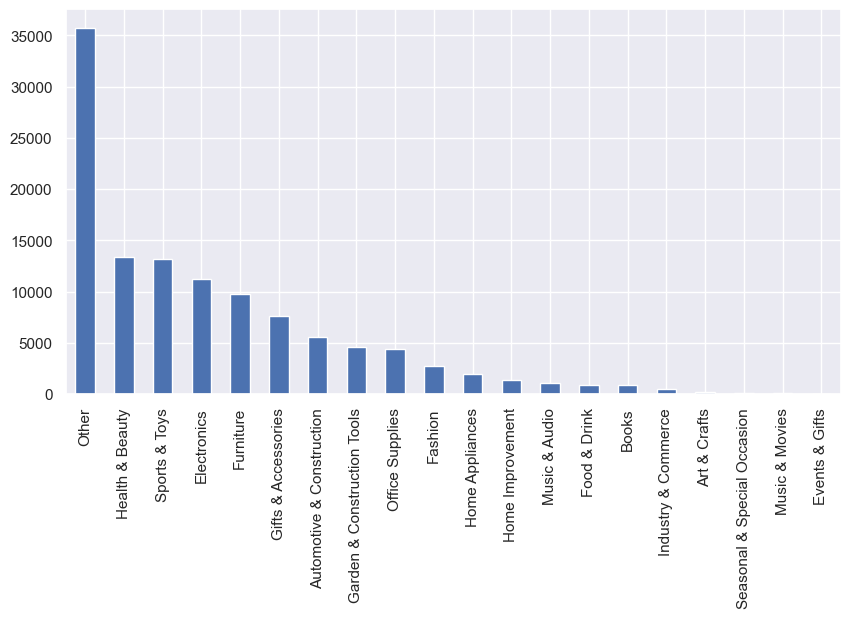

In [8]:
plt.figure(figsize=(10,5))
df['PRODUCT_CATEGORY_NAME_ENGLISH'].value_counts().plot(kind='bar')

In [9]:
df.head()

,CUSTOMER_STATE,REVIEW_SCORE,ORDER_STATUS,PAYMENT_TYPE,PAYMENT_VALUE,PRODUCT_CATEGORY_NAME_ENGLISH
0,RJ,5.0,delivered,credit_card,72.19,Other
1,SP,4.0,delivered,credit_card,259.83,Other
2,MG,5.0,delivered,credit_card,216.87,Furniture
3,SP,4.0,delivered,credit_card,25.78,Other
4,SP,5.0,delivered,credit_card,218.04,Garden & Construction Tools


### Check the Unique value on REVIEW_SCORE column

In [10]:
df['REVIEW_SCORE'].unique()

array([5., 4., 1., 3., 2.])

In [11]:
def segment_review_score(category):
    if category in [1, 2, 3]:
        return 'Bad Review'
    elif category in [4, 5]:
        return 'Good Review'


# Apply the segmentation function to the DataFrame
df['REVIEW_SCORE'] = df['REVIEW_SCORE'].apply(segment_review_score)

<Axes: >

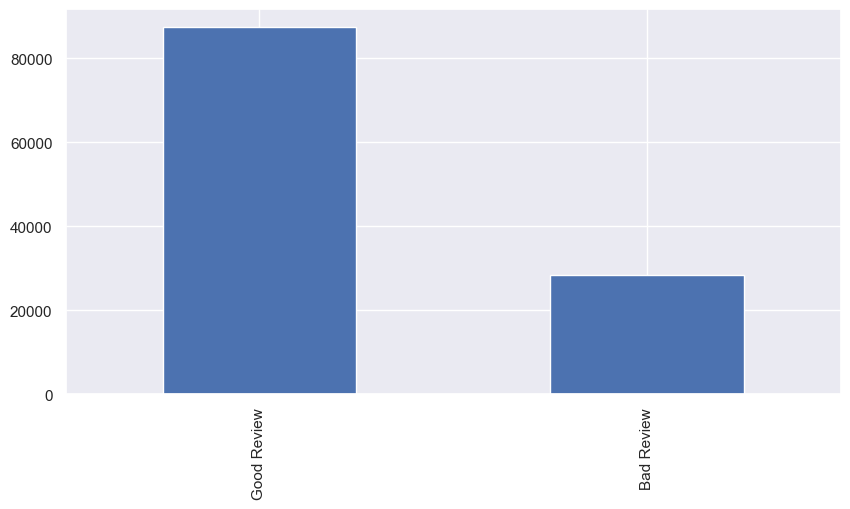

In [12]:
plt.figure(figsize=(10,5))
df['REVIEW_SCORE'].value_counts().plot(kind='bar')

In [13]:
df.head()

,CUSTOMER_STATE,REVIEW_SCORE,ORDER_STATUS,PAYMENT_TYPE,PAYMENT_VALUE,PRODUCT_CATEGORY_NAME_ENGLISH
0,RJ,Good Review,delivered,credit_card,72.19,Other
1,SP,Good Review,delivered,credit_card,259.83,Other
2,MG,Good Review,delivered,credit_card,216.87,Furniture
3,SP,Good Review,delivered,credit_card,25.78,Other
4,SP,Good Review,delivered,credit_card,218.04,Garden & Construction Tools


### Exploratory Data Analysis

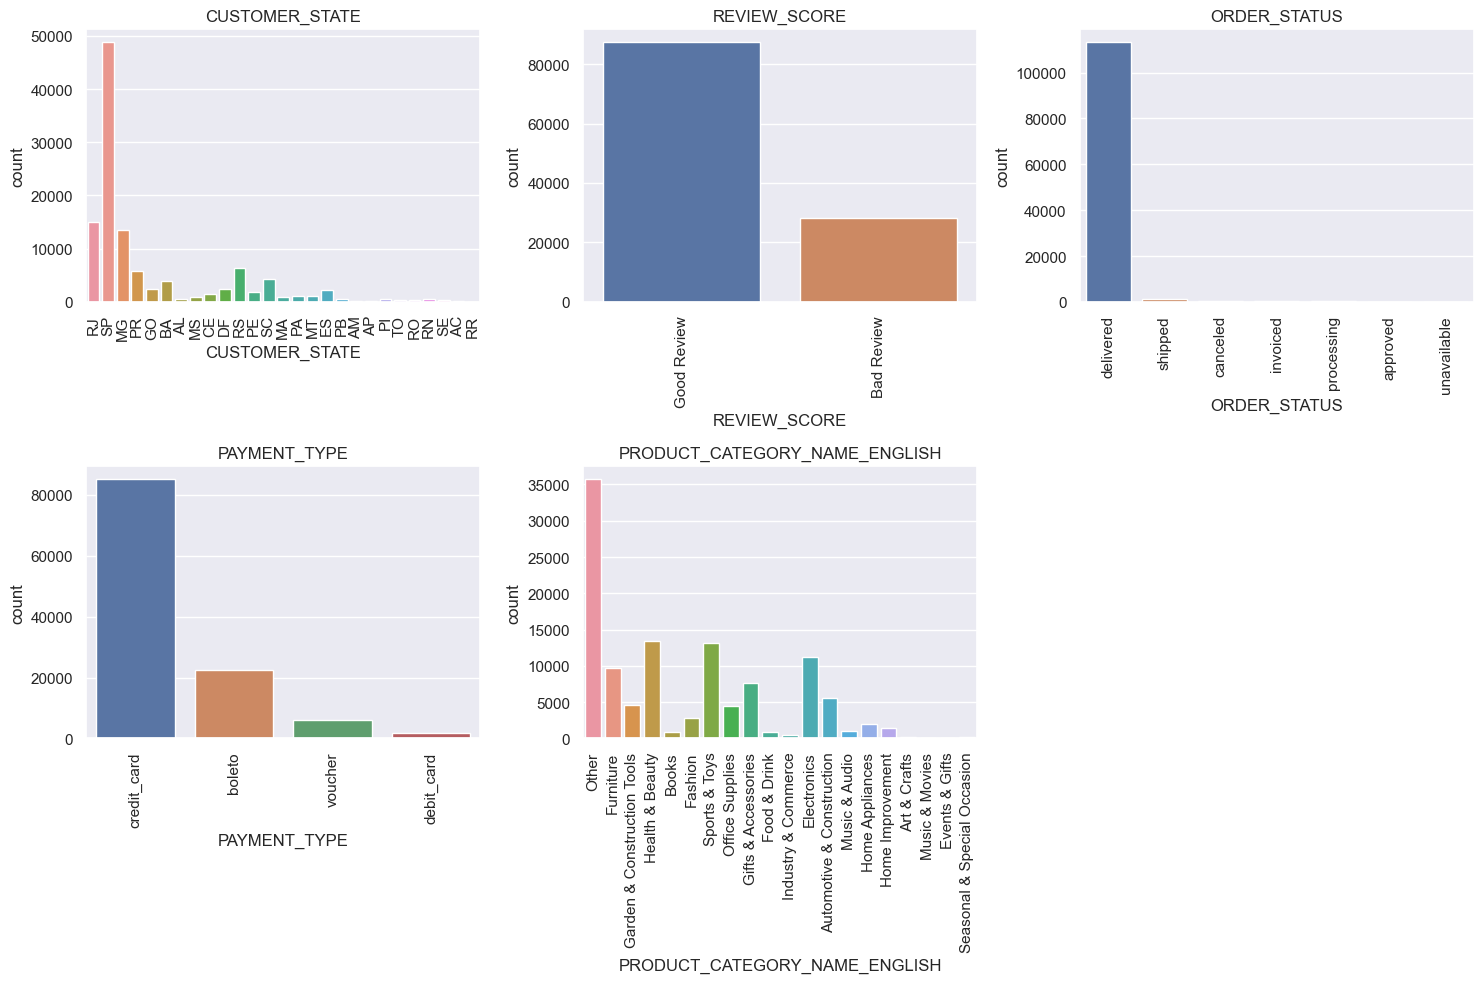

In [15]:
# Get the names of all columns with data type 'object' (categorical columns)
cat_vars = df.select_dtypes(include='object').columns.tolist()

# Create a figure with subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a countplot for each categorical variable using Seaborn
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, data=df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

plt.savefig('barplot_unique.png', dpi=300)

# Show plot
plt.show()

In [16]:
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown

In [17]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="***********************************")

import PIL.Image

img = PIL.Image.open("barplot_unique.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Explain it by points in simple and clear terms. Provide key findings and actionable insights based on the countplot", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> ## Countplot Analysis:
> 
> These countplots provide insights into the distribution of categorical features within a dataset. Here's a breakdown:
> 
> **1. Customer State:**
> 
> - **Key Finding:** The majority of customers are from São Paulo, followed by Rio de Janeiro. The rest of the states have significantly lower customer counts.
> - **Actionable Insights:**
>     - **Targeted Marketing:**  Focus marketing efforts on São Paulo and Rio de Janeiro to maximize reach.
>     - **Regional Expansion:** Consider expanding operations to other states with lower customer counts, particularly those with potential growth. 
> 
> **2. Review Score:**
> 
> - **Key Finding:** A vast majority of customers gave "Good Review", while only a small proportion provided "Bad Review".
> - **Actionable Insights:**
>     - **Maintain Quality:**  The high "Good Review" percentage indicates strong customer satisfaction. Maintain current product and service quality to ensure customer loyalty.
>     - **Address Negative Feedback:** Analyze the "Bad Review" data to identify issues and improve customer experience.
> 
> **3. Order Status:**
> 
> - **Key Finding:** The most frequent order status is "delivered". "Shipped" and "invoiced" are also common, while "canceled", "processing", "approved" and "unavailable" are significantly less common.
> - **Actionable Insights:**
>     - **Efficient Delivery:** The high "delivered" count suggests a well-functioning logistics system. 
>     - **Investigate Issues:** Explore the reasons behind canceled, processing, approved, and unavailable orders to identify potential bottlenecks and improve efficiency.
> 
> **4. Payment Type:**
> 
> - **Key Finding:** The primary payment method is "credit_card", with "boleto" being a distant second. "voucher" is used to a smaller degree, and "debit_card" is used least frequently. 
> - **Actionable Insights:**
>     - **Focus on Credit Card:**  Promote credit card payments as the most preferred option.
>     - **Explore Alternative Payment:**  Offer a wider range of payment options, especially for "boleto" users, to cater to a broader customer base.
> 
> **5. Product Category Name (English):**
> 
> - **Key Finding:**  The most common product categories are "Other", "Furniture", "Garden & Construction Tools" and "Health & Beauty".
> - **Actionable Insights:**
>     - **Product Portfolio:** The high frequency of these categories suggests strong customer demand. Consider expanding inventory within these popular categories.
>     - **Diversification:**  Explore new product categories to cater to a wider range of customer needs and interests, while keeping in mind the popularity of current offerings.
> 
> **Overall:**
> 
> This countplot analysis provides valuable insights into customer behavior, product preferences, and business processes. By leveraging this data, businesses can make data-driven decisions to optimize marketing, product development, and operations for increased profitability and customer satisfaction. 


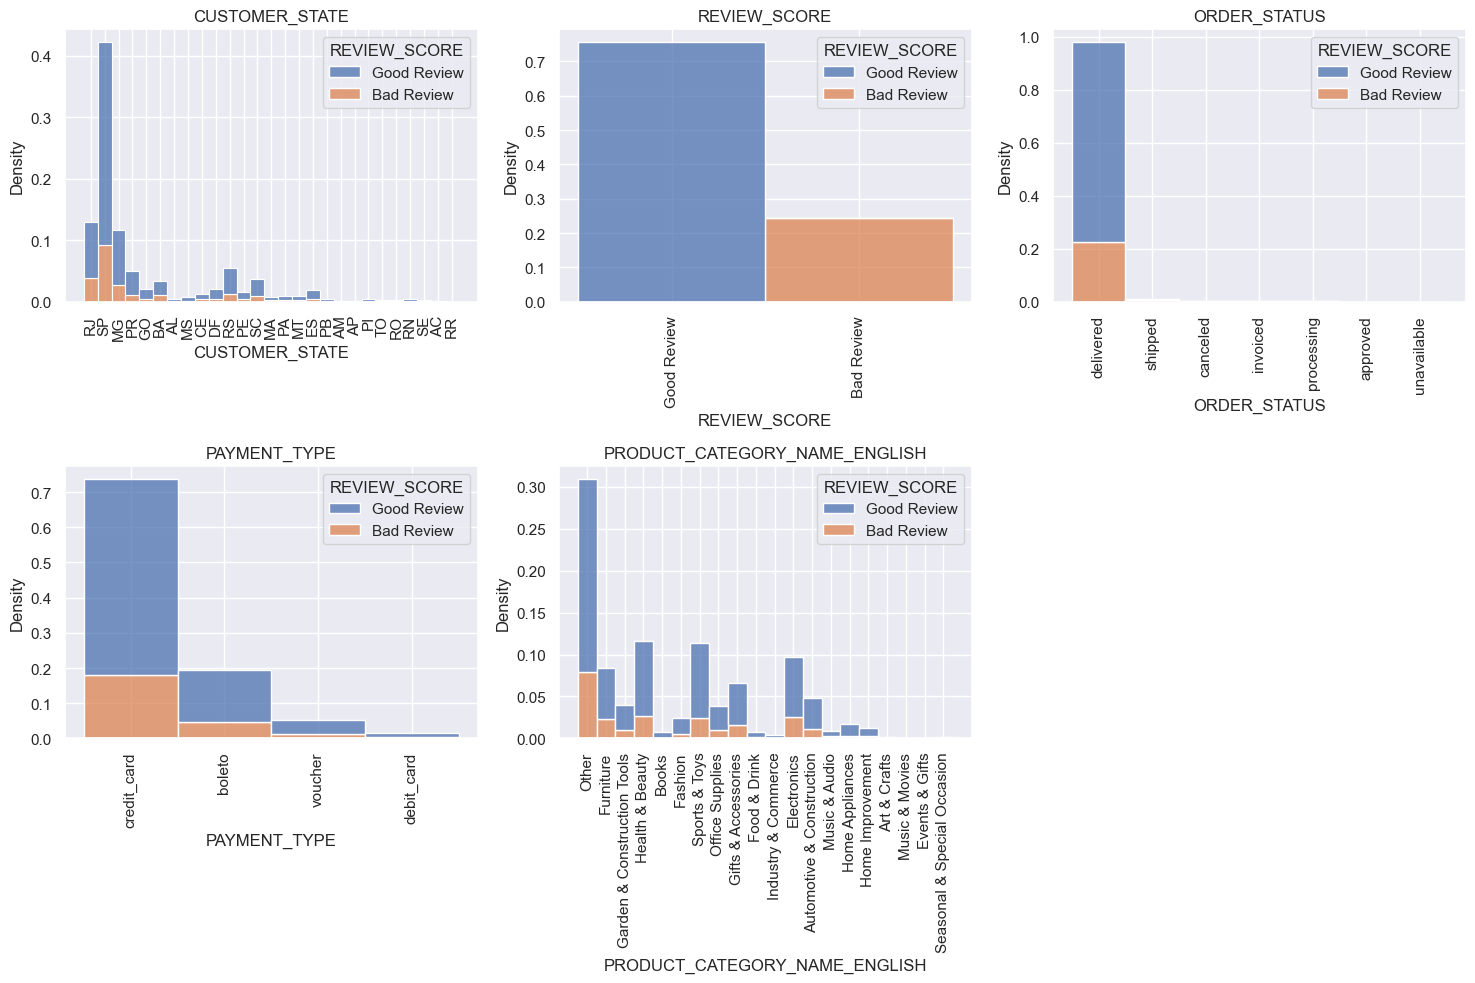

In [21]:
# Get the names of all columns with data type 'object' (categorical columns)
cat_vars = df.select_dtypes(include='object').columns.tolist()

# Create the stacked density plot
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

for i, var in enumerate(cat_vars):
    sns.histplot(data=df, x=var, hue='REVIEW_SCORE', stat='density', multiple='stack', ax=axs[i])
    axs[i].set_title(var)
    axs[i].set_ylabel('Density')
    axs[i].tick_params(axis='x', rotation=90)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

plt.savefig('density_plot.png', dpi=300)

# Show plot
plt.show()

In [23]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*******************************")

import PIL.Image

img = PIL.Image.open("density_plot.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached density plot.",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The density plots show the distribution of different features with respect to customer review scores, categorized as "Good Review" and "Bad Review." Here's an analysis:
> 
> **CUSTOMER_STATE:**  The plot reveals a clear peak in customer reviews for the state "SP." This suggests that a significant portion of customer reviews come from this state. While the distribution for both "Good Review" and "Bad Review" categories is similar, it's noteworthy that the density of "Good Review" is slightly higher than "Bad Review" for the majority of states.
> 
> **REVIEW_SCORE:** This plot confirms the basic classification of reviews. It shows that "Good Review" has a high density, while "Bad Review" has a lower density.  
> 
> **ORDER_STATUS:** This plot demonstrates that "delivered" orders have the highest density for both "Good Review" and "Bad Review." This suggests that a significant portion of reviews are associated with delivered orders. The "shipped" and "canceled" order statuses show a moderate number of reviews, while other order statuses have significantly lower densities.
> 
> **PAYMENT_TYPE:** Credit card payment has the highest density for both "Good Review" and "Bad Review."  This indicates that credit card is the most frequent payment method used by customers.  Interestingly, "boleto" payments have a higher density of "Good Reviews" compared to "Bad Reviews," suggesting a potential relationship between payment method and review scores. 
> 
> **PRODUCT_CATEGORY_NAME_ENGLISH:**  The plot displays a diverse distribution of product categories with varying densities. The highest density for "Good Review" is observed for "Furniture" and "Other" categories. Interestingly, "Gifts & Food & Drink" has a higher density for "Bad Review" compared to "Good Review."
> 
> **Main Findings:**
> 
> * "SP" state has a disproportionately high number of reviews.
> * Credit card is the most popular payment method. 
> * There is a potential correlation between "boleto" payments and higher "Good Review" density.
> * "Furniture" and "Other" product categories tend to have a high proportion of "Good Reviews."
> * "Gifts & Food & Drink" category has a higher proportion of "Bad Reviews."
> 
> **Actionable Insights:**
> 
> * **Targeted Marketing:** Focus marketing efforts on customers from "SP" state, as they have a significant impact on overall reviews.
> * **Payment Options Analysis:**  Explore the relationship between "boleto" payment method and positive reviews. This could potentially lead to strategies for promoting "boleto" payments or understanding its impact on customer satisfaction. 
> * **Product Category Optimization:**  Focus on improving product quality and customer experience for products in the "Gifts & Food & Drink" category to address the higher "Bad Review" density.
> * **Customer Service Improvement:** Implement strategies to improve customer service and satisfaction for orders with different order statuses, particularly those with lower "Good Review" density. 
> * **Review Analysis:** Conduct a deeper analysis of reviews within product categories to identify specific areas for improvement. 


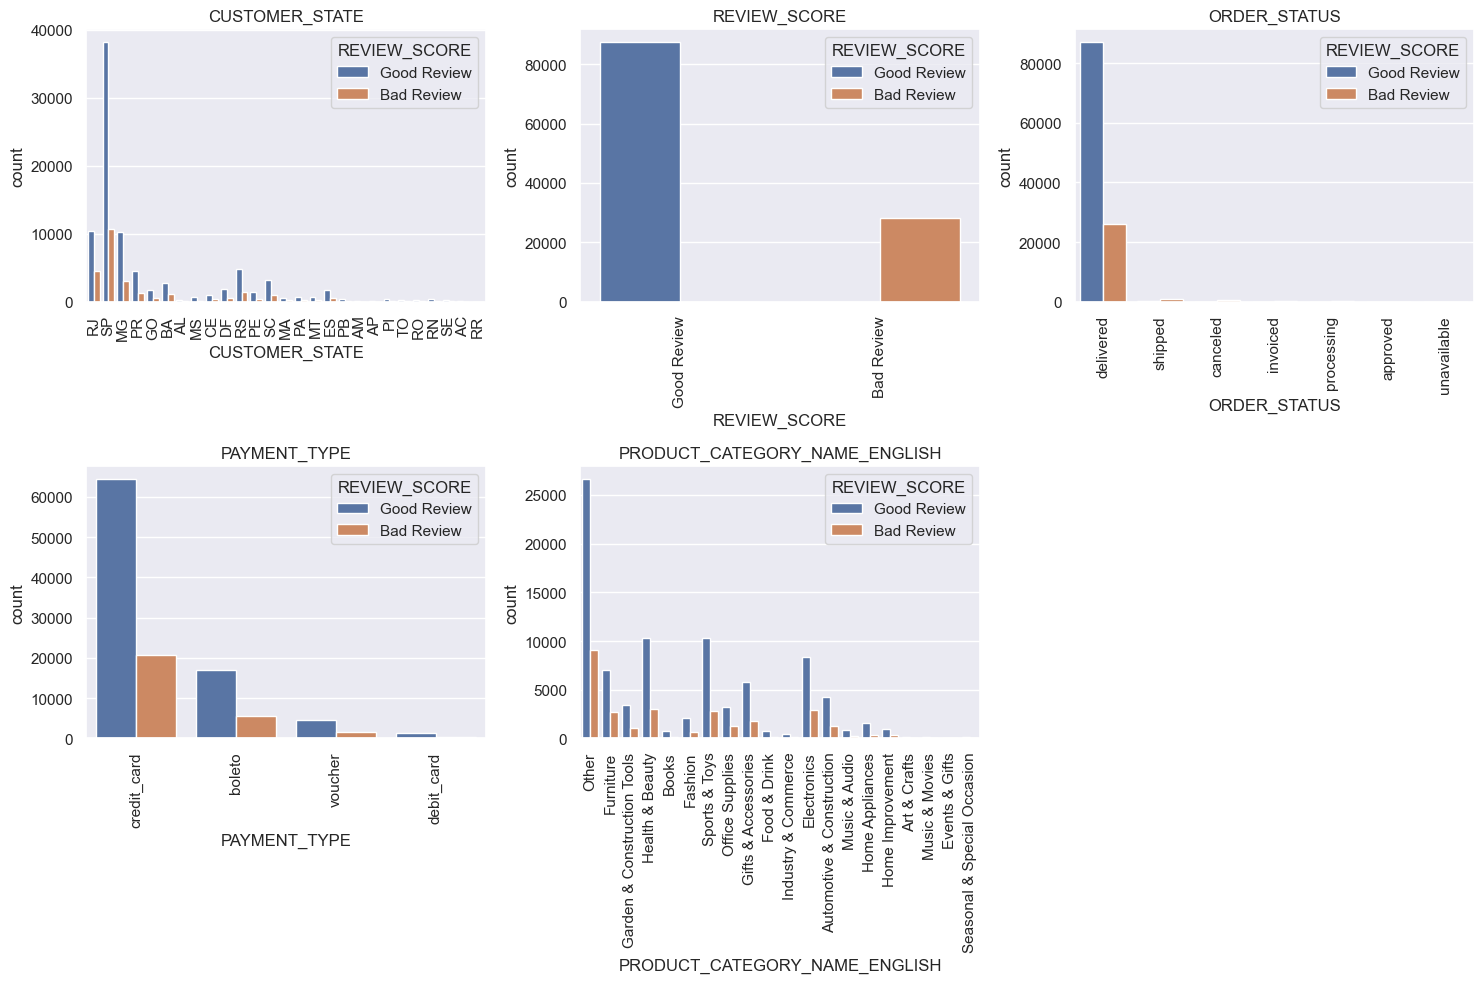

In [24]:
# Get the names of all columns with data type 'object' (categorical columns)
cat_vars = df.select_dtypes(include='object').columns.tolist()

# Create a figure with subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a countplot for each categorical variable using Seaborn with 'Attrition' as hue
for i, var in enumerate(cat_vars):
    sns.countplot(x=var, hue='REVIEW_SCORE', data=df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

plt.savefig('multi_count_plot.png', dpi=300)

# Show plot
plt.show()

In [25]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="***********************************")

import PIL.Image

img = PIL.Image.open("multi_count_plot.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached multiclass countplot.",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The multiclass countplot visualizes the distribution of good and bad reviews across various customer attributes. Let's analyze each plot:
> 
> **CUSTOMER_STATE:** 
> - The plot shows a strong peak for customers from state "SP", indicating a significant number of reviews originating from that state.
> - The distribution is heavily skewed towards "SP", with other states having considerably fewer reviews. 
> - The majority of reviews from "SP" are positive, while a noticeable proportion of reviews from "RJ" are negative.
> - **Actionable Insight:** Focus marketing efforts in "SP", while addressing the negative reviews in "RJ" to improve customer satisfaction.
> 
> **REVIEW_SCORE:** 
> - This plot highlights a clear imbalance in review scores, with a much larger number of good reviews compared to bad reviews. 
> - **Actionable Insight:** This imbalance suggests that the overall customer satisfaction is high, but further investigation is needed to understand the reasons behind negative reviews and address them.
> 
> **ORDER_STATUS:**
> - The majority of orders are in the "delivered" status, followed by "shipped".
> - A small proportion of orders are in "canceled" and "processing" states.
> -  The "unavailable" status has the least number of orders.
> - **Actionable Insight:**  The dominance of "delivered" suggests efficient order fulfillment. Focus on understanding the reasons for cancellations and processing delays to optimize the order management process.
> 
> **PAYMENT_TYPE:** 
> - Credit card is the most frequent payment method, followed by boleto, voucher, and debit card.
> - A higher proportion of negative reviews are associated with "boleto" compared to other payment types.
> - **Actionable Insight:**  Credit card is the preferred payment method, suggesting a need to investigate the reasons behind negative reviews associated with boleto and potentially enhance the payment experience for this method.
> 
> **PRODUCT_CATEGORY_NAME_ENGLISH:** 
> - The plot shows a diverse range of product categories, with "Furniture" having the highest number of reviews, followed by "Garden & Construction Tools".
> - Some product categories, like "Sports & Toys", have more negative reviews than positive reviews.
> - **Actionable Insight:** Focus on understanding the reasons for negative reviews in categories like "Sports & Toys" and potentially consider product improvements or customer service enhancements.
> 
> **Overall Findings:**
> - The dataset predominantly contains positive customer reviews, suggesting a high level of customer satisfaction.
> - Specific states and payment methods exhibit higher proportions of negative reviews, warranting further investigation to address underlying issues.
> - Some product categories have a higher percentage of negative reviews, signifying potential areas for product or service optimization.
> 
> **Actionable Insights:**
> -  Focus marketing efforts in states with high review volume like "SP".
> - Address negative review feedback and implement necessary improvements to enhance customer satisfaction.
> - Investigate and potentially improve payment processing for "boleto" to minimize negative reviews.
> - Analyze and understand the reasons behind negative reviews in specific product categories to implement targeted solutions. 


### Check the amount of missing value on each column

In [26]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean() * 100

# Display the result
print(missing_percentage)

CUSTOMER_STATE                   0.0
REVIEW_SCORE                     0.0
ORDER_STATUS                     0.0
PAYMENT_TYPE                     0.0
PAYMENT_VALUE                    0.0
PRODUCT_CATEGORY_NAME_ENGLISH    0.0
dtype: float64


### Label Encoding for each Object datatype

In [27]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

CUSTOMER_STATE: ['RJ' 'SP' 'MG' 'PR' 'GO' 'BA' 'AL' 'MS' 'CE' 'DF' 'RS' 'PE' 'SC' 'MA'
 'PA' 'MT' 'ES' 'PB' 'AM' 'AP' 'PI' 'TO' 'RO' 'RN' 'SE' 'AC' 'RR']
REVIEW_SCORE: ['Good Review' 'Bad Review']
ORDER_STATUS: ['delivered' 'shipped' 'canceled' 'invoiced' 'processing' 'approved'
 'unavailable']
PAYMENT_TYPE: ['credit_card' 'boleto' 'voucher' 'debit_card']
PRODUCT_CATEGORY_NAME_ENGLISH: ['Other' 'Furniture' 'Garden & Construction Tools' 'Health & Beauty'
 'Books' 'Fashion' 'Sports & Toys' 'Office Supplies' 'Gifts & Accessories'
 'Food & Drink' 'Industry & Commerce' 'Electronics'
 'Automotive & Construction' 'Music & Audio' 'Home Appliances'
 'Home Improvement' 'Art & Crafts' 'Music & Movies' 'Events & Gifts'
 'Seasonal & Special Occasion']


In [28]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:

    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()

    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())

    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])

    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

CUSTOMER_STATE: [18 25 10 17  8  4  1 11  5  6 22 15 23  9 13 12  7 14  2  3 16 26 20 19
 24  0 21]
REVIEW_SCORE: [1 0]
ORDER_STATUS: [2 5 1 3 4 0 6]
PAYMENT_TYPE: [1 0 3 2]
PRODUCT_CATEGORY_NAME_ENGLISH: [17  7  8 10  2  5 19 16  9  6 13  3  1 14 11 12  0 15  4 18]


### Correlation Heatmap

<Axes: >

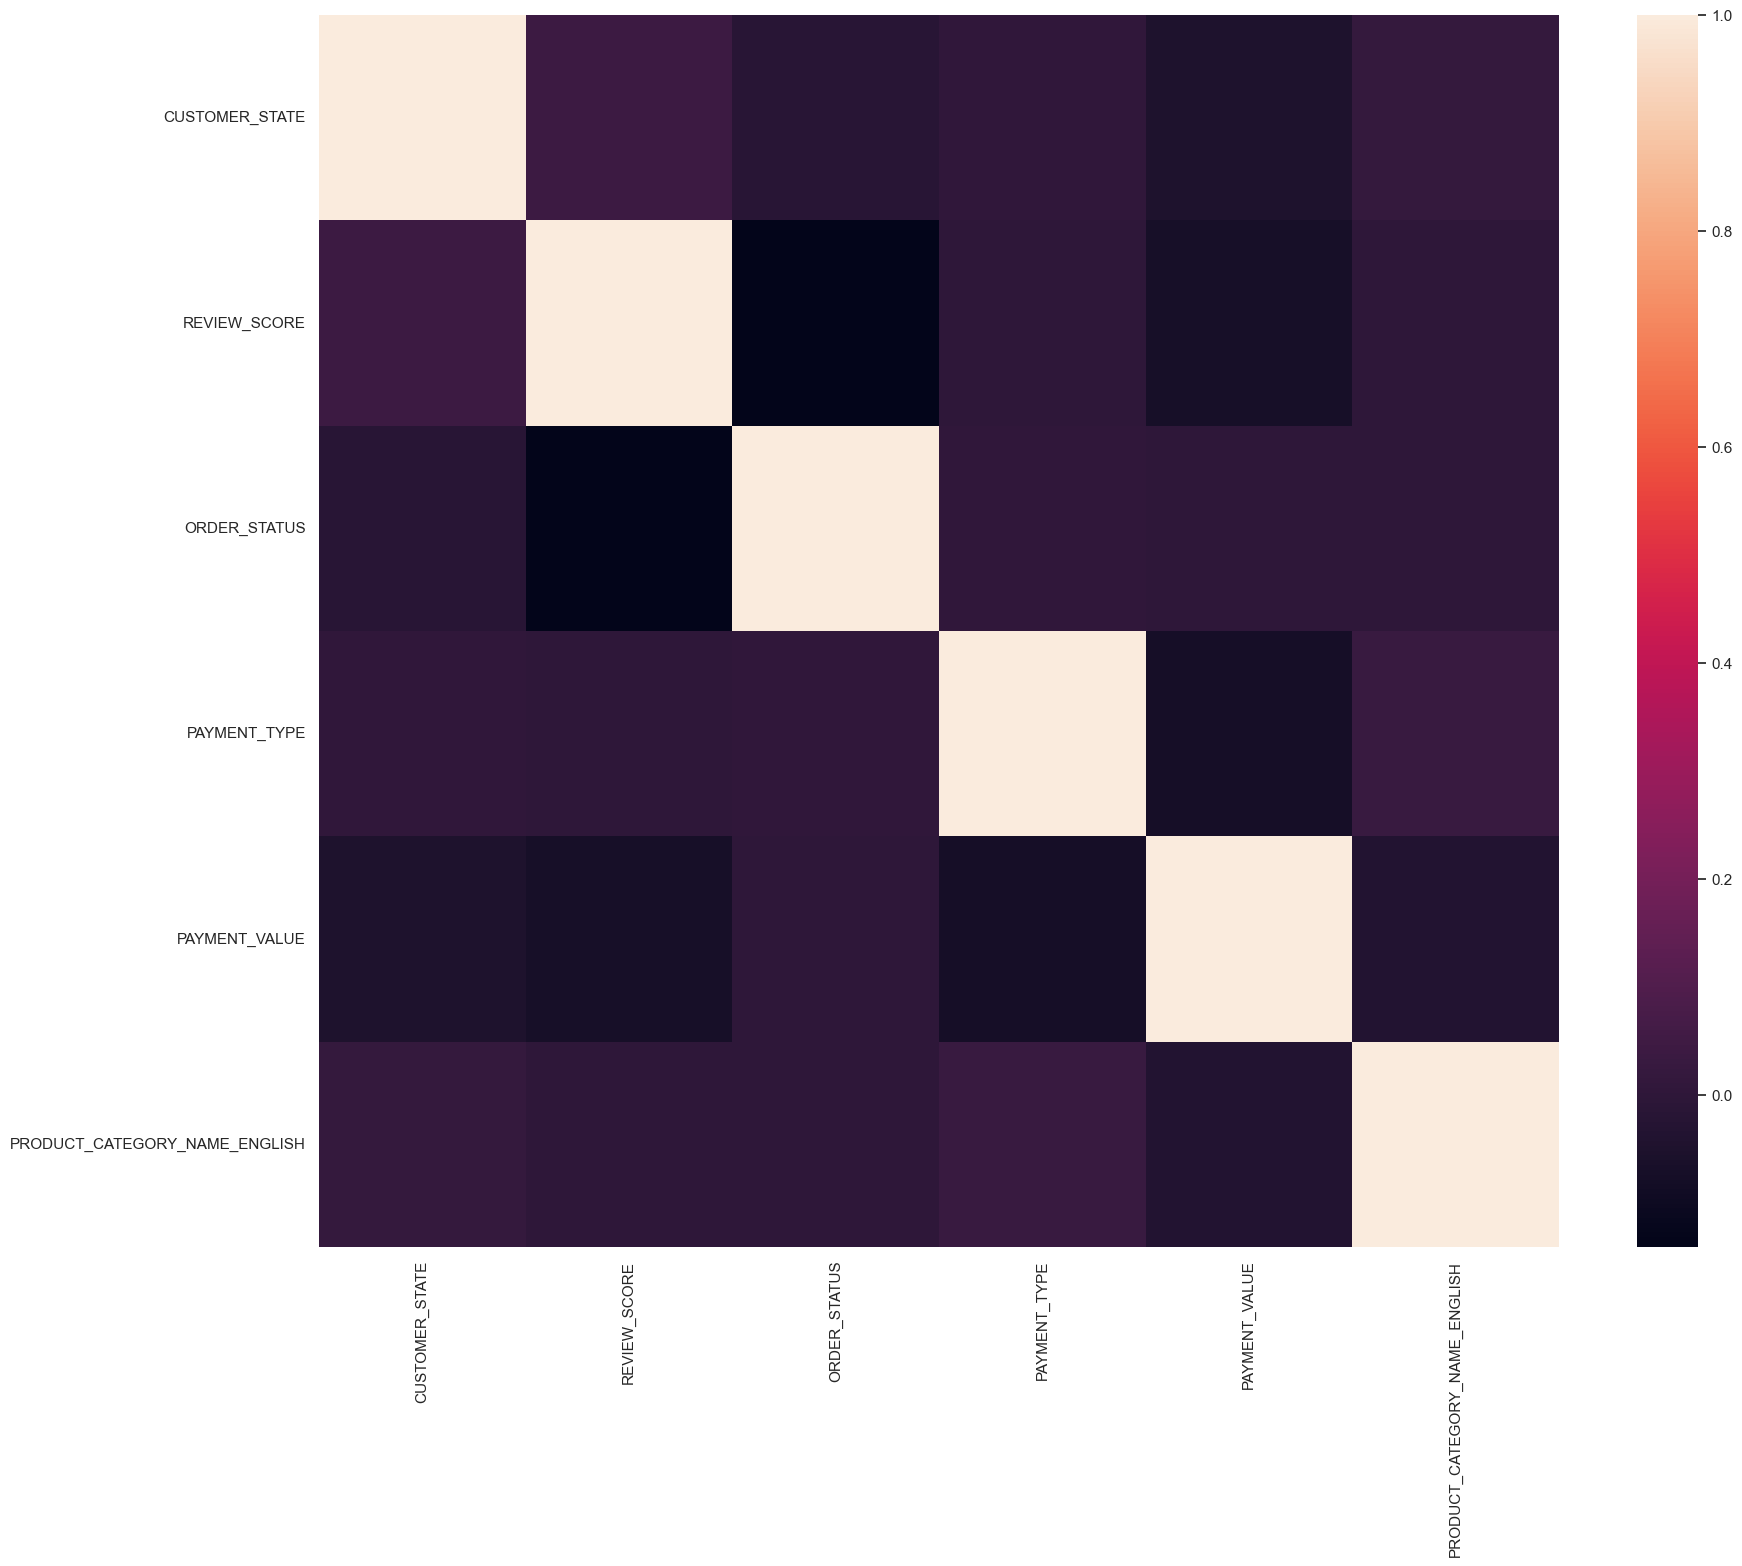

In [29]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), fmt='.2g')

### Train Test Split

In [30]:
X = df.drop('REVIEW_SCORE', axis=1)
y = df['REVIEW_SCORE']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Remove Outlier from train data using Z-Score

In [32]:
from scipy import stats

# Define the columns for which you want to remove outliers
selected_columns = ['PAYMENT_TYPE']

# Calculate the Z-scores for the selected columns in the training data
z_scores = np.abs(stats.zscore(X_train[selected_columns]))

# Set a threshold value for outlier detection (e.g., 3)
threshold = 3

# Find the indices of outliers based on the threshold
outlier_indices = np.where(z_scores > threshold)[0]

# Remove the outliers from the training data
X_train = X_train.drop(X_train.index[outlier_indices])
y_train = y_train.drop(y_train.index[outlier_indices])

### Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dtree = DecisionTreeClassifier(class_weight='balanced')
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [0, 42]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}


In [38]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=2, min_samples_split=2, class_weight='balanced')
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=2,
                       random_state=0)

In [39]:
from sklearn.metrics import accuracy_score
y_pred = dtree.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 66.04 %


In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.660409999135023
Precision Score :  0.660409999135023
Recall Score :  0.660409999135023
Jaccard Score :  0.4929941241040873
Log Loss :  12.240064285587229


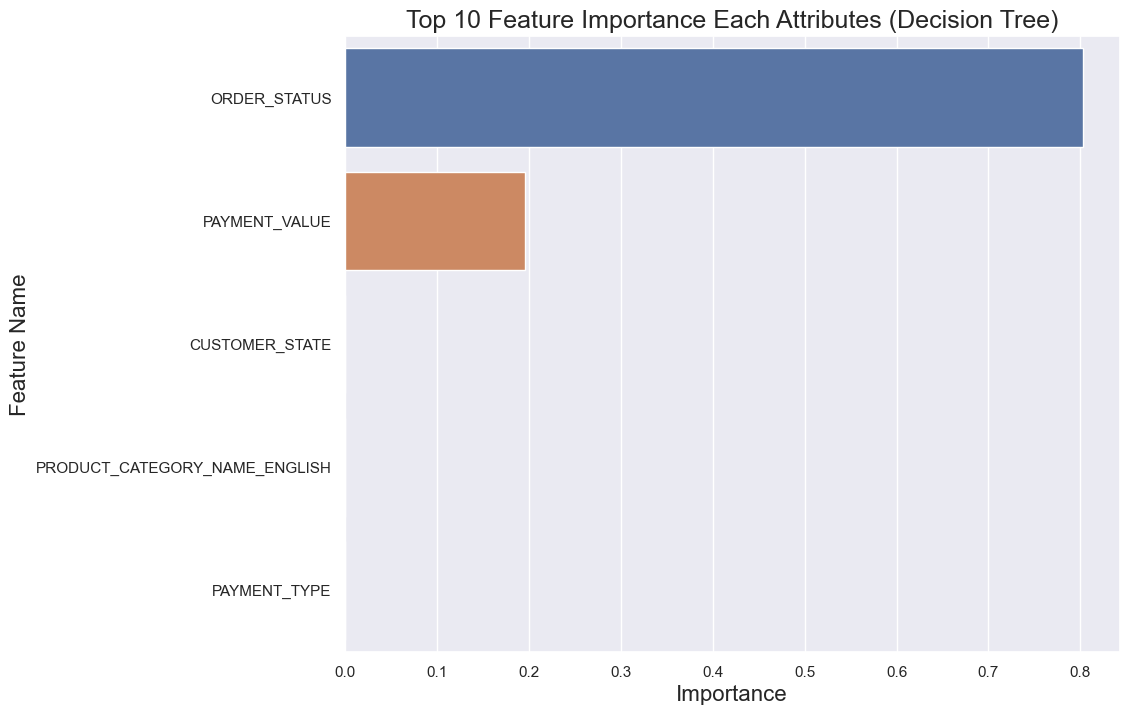

In [41]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.savefig('feature_importance_dtree.png', format='png', bbox_inches='tight')
plt.show()

In [42]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*********************************")

import PIL.Image

img = PIL.Image.open("feature_importance_dtree.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached decision tree feature importance.",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The plot shows the top 10 feature importance for a decision tree model.
> 
> **Key Features:**
> 
> * **Peaks:** The most important feature is `ORDER_STATUS` with an importance score of around 0.8. The second most important feature is `PAYMENT_VALUE` with an importance score of around 0.2. 
> * **Distribution:** The importance scores are highly skewed, with a few features having significantly higher importance than others.
> * **Noticeable Patterns:** The features with low importance scores are clustered together at the bottom of the plot.
> 
> **Main Findings:**
> 
> The decision tree model found that `ORDER_STATUS` and `PAYMENT_VALUE` are the most important features for predicting the target variable. The other features are much less important.
> 
> **Actionable Insights:**
> 
> * **Focus on the most important features:** Since `ORDER_STATUS` and `PAYMENT_VALUE` are the most important features, it is essential to collect accurate data on these features and use them effectively in the model.
> * **Improve data quality:** The model's performance may be improved by improving the data quality for the most important features.
> * **Consider removing less important features:** Since the features with low importance scores are not contributing much to the model's performance, they can be removed to simplify the model and potentially improve its performance.
> * **Explore other features:** While the decision tree model found that `ORDER_STATUS` and `PAYMENT_VALUE` are the most important features, it is possible that other features may be more important when using other machine learning algorithms. It is worth exploring other features to see if they can improve the model's performance.
> 
> **Overall, the feature importance plot provides valuable insights into the decision tree model's performance and helps identify which features are most important for predicting the target variable.**

Text(0.5, 1.0, 'Accuracy Score for Decision Tree: 0.660409999135023')

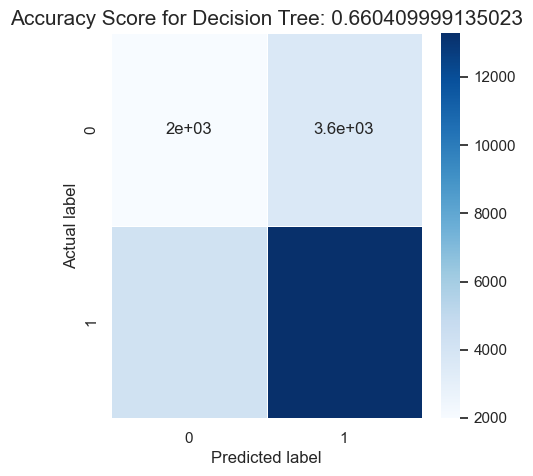

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

### Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, max_depth=None, max_features=None, n_estimators=100, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       random_state=0)

In [46]:
y_pred = rfc.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 75.86 %


In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.7586281463541216
Precision Score :  0.7586281463541216
Recall Score :  0.7586281463541216
Jaccard Score :  0.6111207887677246
Log Loss :  8.699923430700755


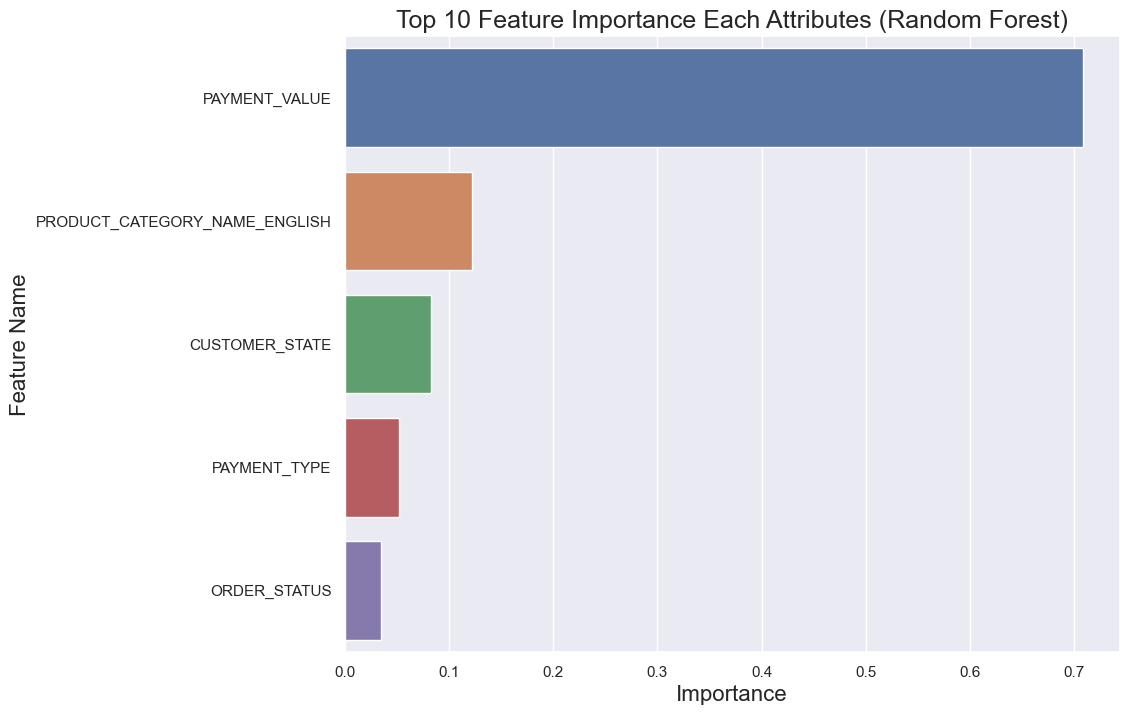

In [48]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": rfc.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.savefig('feature_importance_rf.png', format='png', bbox_inches='tight')
plt.show()

In [49]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="***********************************")

import PIL.Image

img = PIL.Image.open("feature_importance_rf.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached random forest feature importance.",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The plot displays the top 10 most important features for a Random Forest model.  Here's an analysis:
> 
> **Peaks:**
> 
> - The most important feature is **PAYMENT_VALUE**. Its importance score is significantly higher than the rest, indicating a strong correlation with the target variable.
> 
> **Distribution:**
> 
> - The importance scores of the features have a decreasing trend, with PAYMENT_VALUE having the highest importance and the other features gradually decreasing in importance. This suggests a clear hierarchy of feature relevance.
> 
> **Noticeable Patterns:**
> 
> - The features related to customer information and order details have relatively higher importance compared to others. This suggests that factors such as payment value, product category, customer state, and payment type play a significant role in the prediction task.
> 
> **Main Findings:**
> 
> - **PAYMENT_VALUE** is the most influential feature in the model. This implies that the amount paid for a purchase is a strong indicator of the outcome.
> - **PRODUCT_CATEGORY_NAME_ENGLISH** is the second most important feature. This suggests that the type of product ordered is also a significant factor.
> - **CUSTOMER_STATE** has moderate importance, indicating that the customer's location may have some impact on the prediction.
> 
> **Actionable Insights:**
> 
> - **Focus on Payment Value:**  Analyze the data further to understand the relationship between payment value and the target variable. Identify patterns and potential thresholds for better decision-making.
> - **Target Specific Product Categories:**  Use the information about product categories to optimize marketing efforts and target specific customer segments.
> - **Explore Customer State Significance:**  Investigate whether different customer states exhibit distinct patterns in the target variable. This could lead to personalized strategies based on location.
> - **Consider Additional Features:**  Explore other features that might have potential importance but are not included in the top 10. This could involve feature engineering and further analysis to identify hidden relationships.
> - **Model Validation and Improvement:**  Evaluate the overall performance of the model and consider techniques like hyperparameter tuning to enhance its accuracy and predictive power.

# Clustering Analysis

In [50]:
query = "SELECT * FROM public.clustering_data_mart"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_9552\411350309.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,PRICE,FREIGHT_VALUE,PRODUCT_WEIGHT_G,PRODUCT_LENGTH_CM,PRODUCT_HEIGHT_CM,PRODUCT_WIDTH_CM,REVIEW_SCORE,PRODUCT_CATEGORY_NAME_ENGLISH
0,58.90,13.29,650.0,28.0,9.0,14.0,5.0,cool_stuff
1,239.90,19.93,30000.0,50.0,30.0,40.0,4.0,pet_shop
2,199.00,17.87,3050.0,33.0,13.0,33.0,5.0,furniture_decor
3,12.99,12.79,200.0,16.0,10.0,15.0,4.0,perfumery
4,199.90,18.14,3750.0,35.0,40.0,30.0,5.0,garden_tools


### Pick the Attribute for Clustering

In [51]:
X=df[["PRICE","FREIGHT_VALUE", "REVIEW_SCORE"]]
X.head()

,PRICE,FREIGHT_VALUE,REVIEW_SCORE
0,58.90,13.29,5.0
1,239.90,19.93,4.0
2,199.00,17.87,5.0
3,12.99,12.79,4.0
4,199.90,18.14,5.0


### Check the Elbow Method

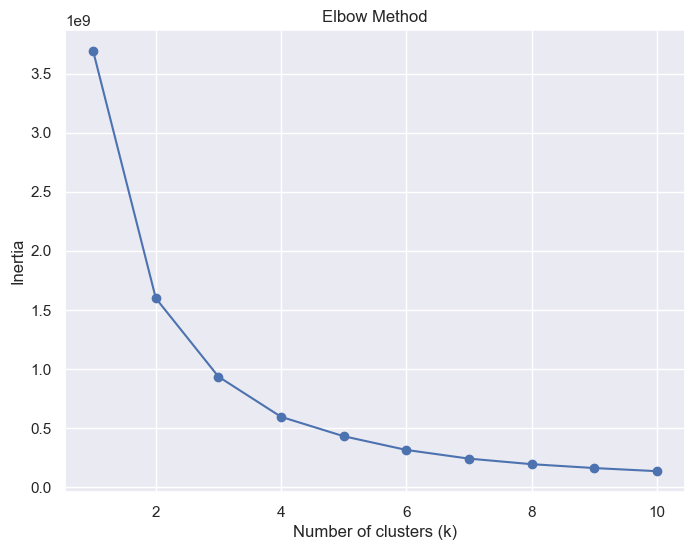

In [55]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to find optimal k using the Elbow Method
def find_optimal_k_elbow(X, max_k):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Plot Elbow graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

selected_columns = ["PRICE","FREIGHT_VALUE", "REVIEW_SCORE"]
X = df[selected_columns]
X = df[selected_columns].dropna()

# Mencari nilai k optimal menggunakan Elbow Method
max_k = 10
find_optimal_k_elbow(X, max_k)

In [60]:
df = df[selected_columns].dropna()
# Make 4 Clusters
from sklearn.cluster import KMeans
km1=KMeans(n_clusters=4, random_state=0)
km1.fit(X)
y=km1.predict(X)
df["cluster"] = y
df.head()

,PRICE,FREIGHT_VALUE,REVIEW_SCORE,cluster
0,58.90,13.29,5.0,1
1,239.90,19.93,4.0,0
2,199.00,17.87,5.0,0
3,12.99,12.79,4.0,1
4,199.90,18.14,5.0,0


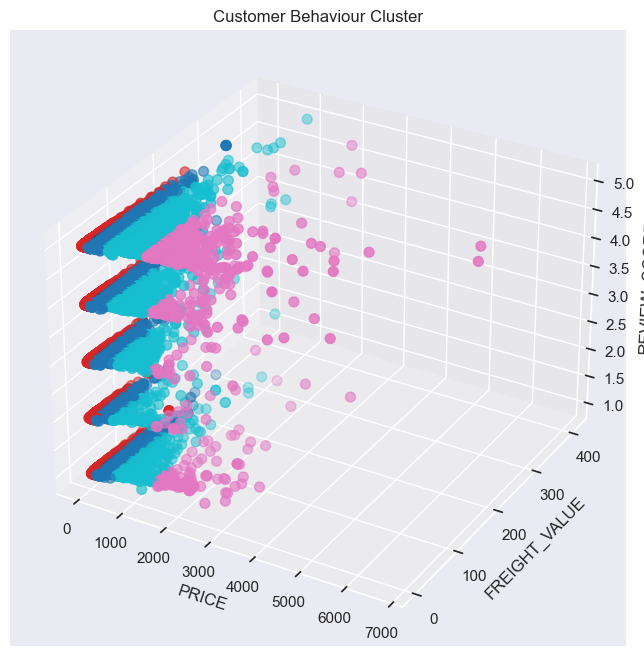

In [62]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Visualization of the Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap for the clusters
colors = plt.cm.tab10(df['cluster'] / float(max(df['cluster'])))

# Plot the data points
ax.scatter(df['PRICE'], df['FREIGHT_VALUE'], df['REVIEW_SCORE'], c=colors, s=50)

# Set labels for the axes
ax.set_xlabel('PRICE')
ax.set_ylabel('FREIGHT_VALUE')
ax.set_zlabel('REVIEW_SCORE')

# Set the title
ax.set_title('Customer Behaviour Cluster')

# Save the plot as a PNG file
plt.savefig('cluster.png', format='png', bbox_inches='tight')

plt.show()

In [63]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="********************************")

import PIL.Image

img = PIL.Image.open("cluster.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached customer behaviour cluster.",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The plot shows a 3D scatter plot of customer behavior clustered into three groups, represented by red, blue, and pink colors. 
> 
> **Key features:**
> 
> * **Peaks:** Each cluster exhibits a peak in the distribution along the price axis. The red cluster shows a peak around 1000, the blue cluster around 2500, and the pink cluster around 4000. This suggests a trend where customers tend to gravitate toward specific price ranges for their purchases.
> * **Distributions:** The red and blue clusters have a relatively narrow distribution along the price axis, indicating a stronger preference for specific price points. The pink cluster exhibits a broader distribution, suggesting a wider range of prices that customers are comfortable with.
> * **Noticeable patterns:** 
>     * There's a noticeable pattern of clusters forming "layers" along the price axis. The red cluster is primarily concentrated at the lower end of the price range, followed by the blue cluster at a slightly higher price range, and then the pink cluster at the highest price range. This suggests a correlation between price and customer behavior.
>     * The clusters also show a distinct pattern along the freight value axis. The red and blue clusters have a higher concentration of points at lower freight values, while the pink cluster has a wider distribution with some points extending to higher freight values. This suggests that customers who buy at lower price ranges are more sensitive to freight costs.
>     *  There is also a trend along the review score axis, with the red cluster having a slightly higher review score overall.
> 
> **Main findings:**
> 
> * Customer behavior is clearly segmented based on price range.
> * Customers in higher price ranges are more willing to pay higher freight costs.
> * Customers at lower price ranges tend to have higher review scores.
> 
> **Actionable insights:**
> 
> * **Target marketing:** Utilize the insights from cluster analysis to tailor marketing strategies for each customer segment. For example, focus on promotions and value-oriented messaging for the red cluster, emphasize quality and features for the blue cluster, and target high-income earners and luxury goods for the pink cluster.
> * **Pricing strategies:** Consider adjusting pricing strategies based on the observed preferences of each customer segment. The observed price peaks might indicate optimal pricing points for each segment.
> * **Freight optimization:** Analyze the freight costs associated with each segment and find ways to optimize shipping costs for the red and blue clusters. This might involve offering free shipping or discounted shipping options for these segments.
> * **Review management:** Focus on maintaining high review scores for the red cluster, which seems to be sensitive to product reviews. 
> 
> By understanding and leveraging these insights, businesses can create targeted strategies to optimize their customer experience, increase sales, and improve overall business outcomes.


# NLP Analysis

In [76]:
query = "SELECT * FROM public.nlp_data_mart"
df = pd.read_sql_query(query, connection)
df.head()

,REVIEW_COMMENT_MESSAGE,PRODUCT_CATEGORY_NAME_ENGLISH
0,"Perfeito, produto entregue antes do combinado.",cool_stuff
1,Chegou antes do prazo previsto e o produto sur...,furniture_decor
2,Gostei pois veio no prazo determinado .,garden_tools
3,Na descrição do produto quando fui efetuar a c...,health_beauty
4,A caixa do produto veio com uma pequena avaria...,health_beauty


In [79]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string

### Show the top 10 Bigrams

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


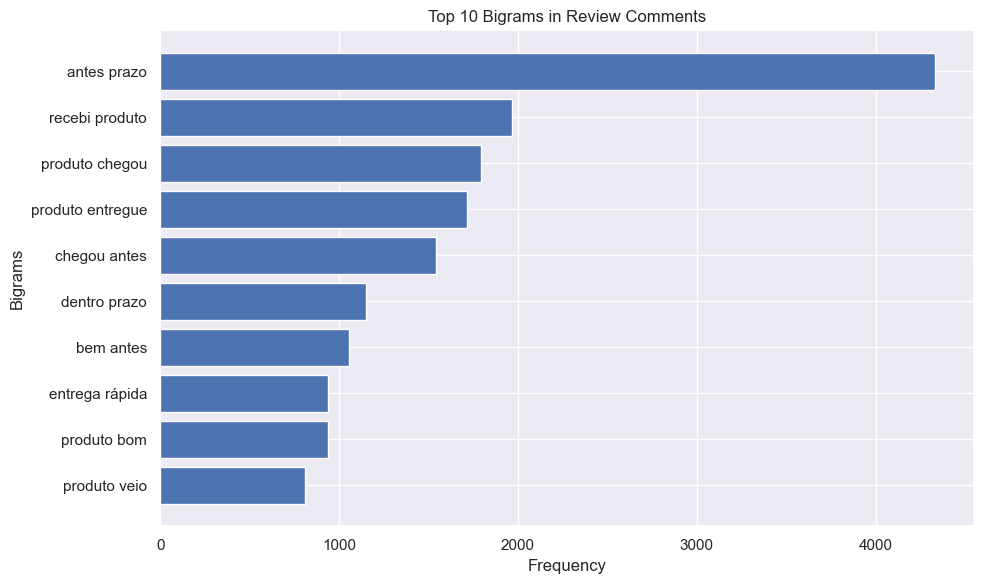

In [83]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize by splitting on whitespace
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Apply preprocessing
df['tokens'] = df['REVIEW_COMMENT_MESSAGE'].apply(preprocess_text)

# Generate bigrams
all_bigrams = [bigram for tokens in df['tokens'] for bigram in bigrams(tokens)]
bigram_freq = FreqDist(all_bigrams)

# Get the top 10 bigrams
top_10_bigrams = bigram_freq.most_common(10)

# Plot the top 10 bigrams
bigram_labels, bigram_counts = zip(*top_10_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

plt.figure(figsize=(10, 6))
plt.barh(bigram_labels, bigram_counts)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 10 Bigrams in Review Comments')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()

# Save the bigram bar chart
plt.savefig('top_10_bigrams.png')
plt.show()

In [84]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*********************************")

import PIL.Image

img = PIL.Image.open("top_10_bigrams.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached top 10 bigrams in review comments (language in bigrams : portuguese)",
        "Explain in english the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize in english the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The plot shows the top 10 bigrams in review comments written in Portuguese. 
> 
> The bigram "antes prazo" (before deadline) has the highest frequency, followed by "recebi produto" (received product) and "produto chegou" (product arrived). This indicates that customers are frequently discussing delivery times and product arrival. 
> 
> The distribution of the bigrams is skewed, with a long tail. This means that there are a few bigrams that occur very frequently, while many others occur less frequently. 
> 
> The plot also reveals a pattern: many of the bigrams are related to the customer experience, particularly around delivery and product quality. "produto entregue" (product delivered), "chegou antes" (arrived early), "dentro prazo" (within deadline), "bem antes" (well before), and "entrega rápida" (fast delivery) all highlight the importance of timely and efficient delivery.
> 
> Other bigrams like "produto bom" (good product), "produto veio" (product came) and "produto bom" (good product) suggest customer satisfaction with the products themselves.
> 
> **Key Findings:**
> 
> * Customer satisfaction is heavily influenced by delivery times and product arrival.
> * Customers are generally pleased with the products themselves.
> 
> **Actionable Insights:**
> 
> * Focus on optimizing delivery processes and communicating delivery times clearly.
> * Continue to offer high-quality products that meet customer expectations.
> * Monitor customer feedback for recurring themes and address any concerns promptly.
> * Implement a customer service system that allows customers to easily share their feedback and experience.

### Show the Wordcloud

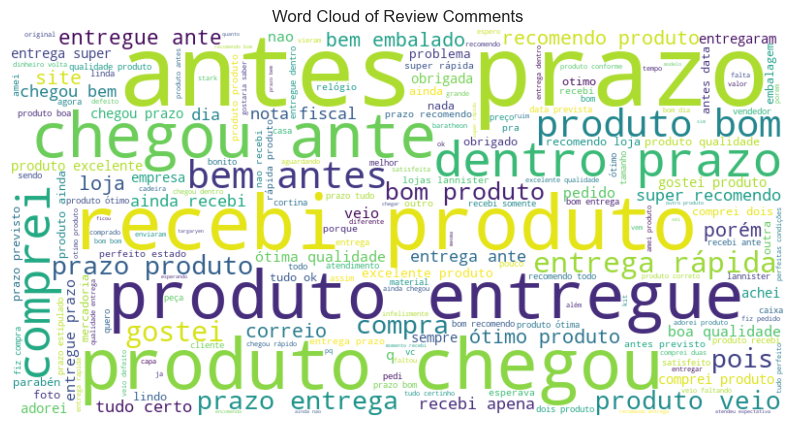

In [85]:
# Create a word cloud
all_words = ' '.join([' '.join(tokens) for tokens in df['tokens']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display and save the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Comments')
plt.savefig('word_cloud.png')
plt.show()

In [86]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*********************************")

import PIL.Image

img = PIL.Image.open("word_cloud.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached wordcloud in review comments (language in wordcloud : portuguese)",
        "Explain in english the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize in english the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The word cloud, generated from Portuguese review comments, highlights several key aspects of customer experience. 
> 
> **Peaks:**
> 
> * **"Produto" (product)** is the largest and most prominent word, suggesting its central importance in the reviews. 
> * **"Entrega" (delivery)** and **"Prazo" (deadline)** are also highly visible, indicating that timely delivery is crucial for customer satisfaction.
> * **"Chegou" (arrived), "Recebi" (received)** and **"Antes" (before)** are strongly emphasized, indicating that customers value prompt delivery and meeting expectations. 
> 
> **Distributions:**
> 
> * Words related to product quality, such as "bom" (good), "ótima" (excellent), and "qualidade" (quality), are clustered closely with "produto," suggesting a strong focus on product satisfaction. 
> * Words related to delivery experience, such as "rapida" (fast), "super" (super), and "comprei" (bought), are located around "entrega" and "prazo," indicating that delivery speed and efficiency are highly valued.
> * The words "antes" (before) and "prazo" (deadline) are often used together, highlighting the importance of meeting deadlines.
> 
> **Patterns:**
> 
> * The word cloud demonstrates a strong emphasis on positive aspects, with terms like "bom" (good), "ótimo" (excellent), and "super" (super) appearing frequently.
> * While there are some negative words like "problema" (problem) and "falta" (lack), they are less prevalent compared to positive terms.
> 
> **Main Findings:**
> 
> * The reviews focus heavily on product quality and timely delivery. 
> * Customers value quick delivery and meeting expected deadlines. 
> * Positive experiences with the product and delivery are highly emphasized.
> 
> **Actionable Insights:**
> 
> * **Prioritize product quality:** Continuously improve product quality and ensure consistency to maintain customer satisfaction. 
> * **Optimize delivery process:** Focus on delivering orders on time or even earlier. Invest in efficient logistics and communication systems to ensure transparency and timely updates.
> * **Emphasize positive experiences:** Encourage customers to share their positive feedback, showcasing successful deliveries and product quality. 
> * **Address negative feedback proactively:** Respond to negative comments swiftly and address any issues promptly to demonstrate customer-centricity. 


# Sales Analysis

In [87]:
query = "SELECT * FROM public.sales_analysis_data_mart"
df = pd.read_sql_query(query, connection)
df.head()

,PRICE,FREIGHT_VALUE,ORDER_PURCHASE_TIMESTAMP,ORDER_DELIVERED_CUSTOMER_DATE,PRODUCT_CATEGORY_NAME_ENGLISH
0,58.90,13.29,2017-09-13 08:59:02,2017-09-20 23:43:48,cool_stuff
1,239.90,19.93,2017-04-26 10:53:06,2017-05-12 16:04:24,pet_shop
2,199.00,17.87,2018-01-14 14:33:31,2018-01-22 13:19:16,furniture_decor
3,12.99,12.79,2018-08-08 10:00:35,2018-08-14 13:32:39,perfumery
4,199.90,18.14,2017-02-04 13:57:51,2017-03-01 16:42:31,garden_tools


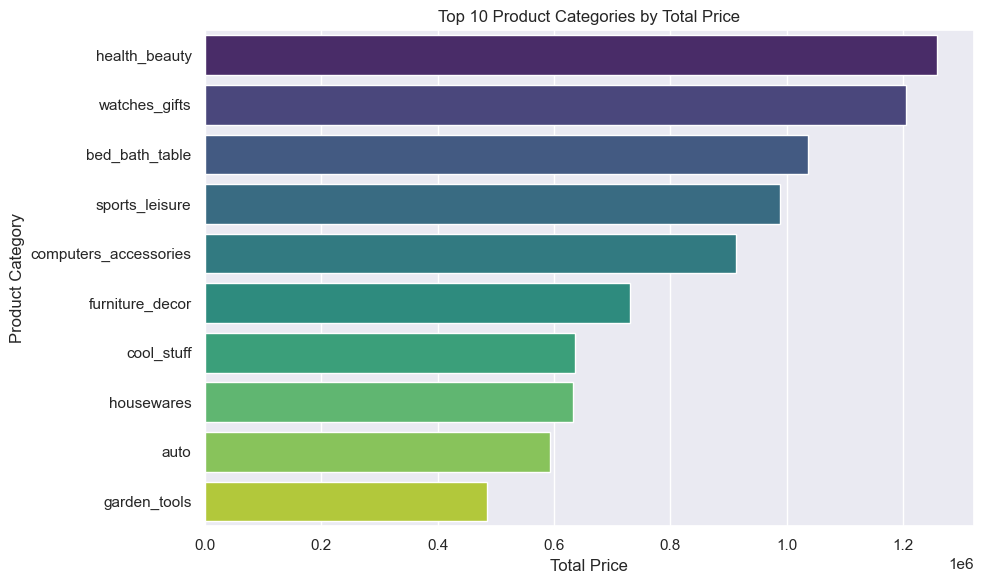

In [88]:
# Group by 'PRODUCT_CATEGORY_NAME_ENGLISH' and calculate the sum of 'PRICE'
category_price_sum = df.groupby('PRODUCT_CATEGORY_NAME_ENGLISH')['PRICE'].sum().reset_index()

# Sort by sum of 'PRICE' and get the top 10
top_10_categories = category_price_sum.sort_values(by='PRICE', ascending=False).head(10)

# Plotting the bar chart using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x='PRICE', y='PRODUCT_CATEGORY_NAME_ENGLISH', data=top_10_categories, palette='viridis')
plt.xlabel('Total Price')
plt.ylabel('Product Category')
plt.title('Top 10 Product Categories by Total Price')
plt.tight_layout()

# Save the plot
plt.savefig('top_10_product_categories_by_price.png')

# Show the plot
plt.show()

In [90]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="****************************")

import PIL.Image

img = PIL.Image.open("top_10_product_categories_by_price.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached top 10 product categories by total price",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The plot shows the top 10 product categories by total price. 
> 
> **Key features:**
> 
> * **Peaks:** The highest peak is at "health_beauty", followed by "watches_gifts", and "bed_bath_table".
> * **Distribution:** The distribution is skewed to the right, with a few categories having significantly higher total prices than the rest.
> * **Noticeable patterns:** There is a clear trend of decreasing total price as we move down the list, indicating that the top categories are significantly more popular than the others.
> 
> **Main findings:**
> 
> * Health and beauty products are the most popular category in terms of total price.
> * Watches and gifts are also a very popular category.
> * There is a significant difference in total price between the top 3 categories and the rest of the list.
> 
> **Actionable insights:**
> 
> * **Focus on promoting health and beauty products.** These products are clearly very popular and have the potential to generate significant revenue.
> * **Consider expanding the selection of watches and gifts.** These products are also very popular, so expanding the selection could lead to increased sales.
> * **Investigate why the remaining categories are less popular.** This could be due to factors such as product availability, pricing, or marketing. By addressing these issues, it may be possible to increase sales in these categories.
> * **Consider offering discounts or promotions on the less popular categories.** This could help to attract more customers and increase sales.
> 
> Overall, the plot provides valuable insights into the popularity of different product categories. By analyzing these insights, businesses can make informed decisions about their product offerings and marketing strategies.

# Power BI Dashboard Analysis

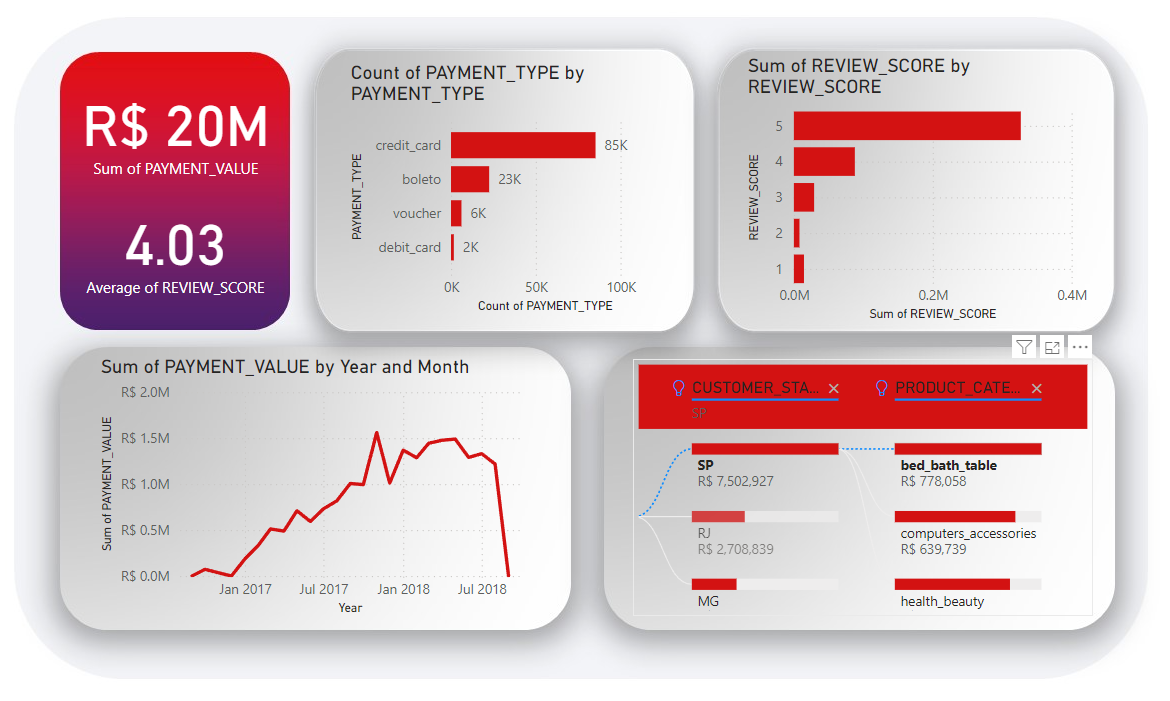

In [91]:
from IPython.display import Image, display

# Display the image
display(Image(filename='dashboard1.PNG'))

In [92]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="******************************")

import PIL.Image

img = PIL.Image.open("dashboard1.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([ "Analyze the attached Power BI Dashboard about Brazilian e-commerce",
        "Explain the key features such as peaks, distributions, and noticeable patterns.",
        "Summarize the main findings and offer actionable insights based on the plot.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The Power BI dashboard provides insights into the performance of a Brazilian e-commerce platform. Let's break down each plot and derive actionable insights.
> 
> **1. Overview:**
> 
> * **Total Revenue:** The dashboard highlights a total revenue of R$ 20 million, showcasing the platform's significant scale. 
> * **Average Review Score:**  The platform enjoys a commendable average review score of 4.03, suggesting customer satisfaction.
> 
> **2. Payment Type Distribution:**
> 
> * **Credit Card Dominance:** Credit card is the most popular payment method, accounting for a substantial majority (85K) of transactions. This indicates a reliance on a mainstream payment option, which can be both a strength (high adoption) and a potential weakness (dependence).
> * **Other Options:** Boleto, voucher, and debit card account for a smaller but noticeable portion of transactions.  
> 
> **Actionable Insights:**
> 
> * **Diversify Payment Options:** Explore the inclusion of alternative payment options like digital wallets (e.g., Pix) or installments to cater to a wider audience and enhance convenience. 
> * **Optimize Credit Card Processing:**  Leverage the high credit card usage by streamlining the checkout process, offering competitive rates, and collaborating with leading payment gateways to minimize transaction fees.
> 
> **3. Review Score Distribution:**
> 
> * **High Concentration on 5-Star Reviews:** A significant majority of reviews fall under the 5-star category, indicating strong customer satisfaction. 
> * **Fewer 4-Star Reviews:**  There's a lower proportion of 4-star reviews compared to 5-star. This could indicate that customers are either extremely happy or dissatisfied, with fewer experiences falling in between. 
> 
> **Actionable Insights:**
> 
> * **Monitor 4-Star Reviews:**  Scrutinize the reasons behind 4-star reviews, identifying areas where minor improvements can lead to increased customer satisfaction and potentially push reviews closer to the 5-star mark. 
> * **Incentivize Reviews:**  Consider implementing strategies to encourage more reviews, as this can provide valuable feedback and improve overall perception.
> 
> **4. Revenue Trend by Year and Month:**
> 
> * **Strong Growth Trend:** The line chart reveals a consistent upward trend in revenue, indicating positive growth over the period analyzed.
> * **Peak in Late 2017:** The revenue reached a peak in late 2017, suggesting a possible seasonal factor or successful marketing campaign during that period.
> * **Slight Dip in 2018:** There's a slight dip in revenue towards the end of 2018. This could be attributed to various factors, such as competition, economic fluctuations, or seasonality.
> 
> **Actionable Insights:**
> 
> * **Identify Peak Seasonality:** Analyze the peak in late 2017 to identify specific products or campaigns that drove success and replicate those efforts in future peak seasons.
> * **Address 2018 Dip:**  Investigate the factors contributing to the revenue dip in 2018, such as competitor activity, product availability, or marketing performance.  Take steps to mitigate such issues in the future.
> * **Forecast Future Revenue:**  Use historical data and seasonal patterns to forecast future revenue, allowing for better planning and resource allocation.
> 
> **5. Top Performing States and Product Categories:**
> 
> * **State-Wise Revenue:** The state of São Paulo (SP) generates the highest revenue, followed by Rio de Janeiro (RJ) and Minas Gerais (MG), indicating a strong regional concentration.
> * **Top Performing Products:**  Bed, bath, and table products generate the highest revenue, followed by computers and accessories and health and beauty products. 
> 
> **Actionable Insights:**
> 
> * **Targeted Marketing in SP:** Invest in tailored marketing efforts within the state of São Paulo to further boost revenue, potentially focusing on customer segments that align with top-performing product categories.
> * **Expansion to Other Regions:** Consider expanding operations to other promising regions in Brazil to diversify revenue streams and reach a wider customer base.
> * **Optimize Product Portfolio:** Analyze the performance of different product categories and focus on expanding those with high demand while potentially streamlining or eliminating underperforming categories.
> 
> By acting on these insights, the Brazilian e-commerce platform can capitalize on its strengths, address areas for improvement, and drive further growth and success in the future.
